<a href="https://colab.research.google.com/github/haytham918/low-rank-expectile/blob/main/LRE_wt_BFGS_Simulates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import scipy
# import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
import time


In [10]:
def normal_data_generator(m, n, r_sd, c_sd, u_sd, v_sd, sigma, na_portion, rank, random_seed):
  """
  Generator function for normal simulated data:
  m: The Number of Rows of Feature Matrix(i.e. number of users)
  n: The Number of Columns of Feature Matrix(i.e. number of items)
  r_sd: The standard deviation of true_r
  c_sd: The standard deviation of true_c
  u_sd: The standard deviation of true_u
  v_sd: The standard deviation of true_v
  sigma: The noise standard deviation
  na_proportion: Proportion of missing data
  rank: (k), The rank for model
  random_seed: self-explained
  """
  np.random.seed(random_seed)
  k = rank

  true_r = norm.rvs(loc=0, size=m, scale=r_sd)
  true_c = norm.rvs(loc=0, size=n, scale=c_sd)

  true_u = norm.rvs(loc=0, size=(m, k), scale=u_sd)
  true_v = norm.rvs(loc=0, size=(n, k), scale=v_sd)

  sigma = sigma

  mu_X = true_r[:, np.newaxis] + true_c + np.dot(true_u, true_v.T)

  error = sigma * norm.rvs(size=(m, n))
  # uv_T = 1 + np.dot(true_u, true_v.T)
  # E = norm.rvs(loc=0, scale=1, size=(m, n))
  # error = uv_T * E
  X = mu_X + error

  prob_miss = na_portion
  missing = np.random.choice([True, False], size=(m, n), p=[prob_miss, 1 - prob_miss])
  X[missing] = np.nan
  return X, true_r, true_c, true_u, true_v

def get_normalized_X(m, n, r_sd, c_sd, u_sd, v_sd, sigma, na_portion, rank):
  X_config, true_r_config, true_c_config, true_u_config, true_v_config = normal_data_generator(m=m, n=n, r_sd=r_sd, c_sd=c_sd, u_sd=u_sd, v_sd=v_sd,sigma=sigma,na_portion=na_portion,rank=rank,random_seed=100)
  #plt.hist(np.dot(true_u, true_v.T).flat)
  #plt.hist((true_r[:, np.newaxis] + true_c ).flat)
  masked_array = np.ma.masked_array(X_config, np.isnan(X_config))
  # X_nona = X[M]
  mean_nona = np.mean(masked_array)
  std_val = np.std(masked_array)
  X_normalized = X_config - mean_nona
  X_normalized /= std_val
  # print("MEAN", mean_nona)
  # print("STD: ", std_val)
  # print("NEW ERROR_SD: ", 0.3/std_val )
  # print(X_normalized)
  X_new = np.ma.array(X_normalized, mask=np.isnan(X_normalized))
  row_mean = np.mean(X_new, 1)
  col_mean = np.mean(X_new, 0)
  # print("NEW MEAN: ", np.mean(X_new))
  # print("NEW STD: ", np.std(X_new))
  return X_config, X_normalized, X_new, true_r_config, true_c_config, true_u_config, true_v_config, row_mean, col_mean

In [3]:
def get_observed_mask(X):
    return ~np.isnan(X)

def compute_expectile_gradients_vectorized(X, R, C, U, V, M, tau):
    m, n = X.shape
    k = U.shape[1]

    # Construct approximation and error matrices
    approx_matrix = R[:, np.newaxis] + C + U @ V.T
    error_matrix = X - approx_matrix
    error_matrix[~M] = 0  # Ignore missing values

    # Get weight
    W = np.where(error_matrix >= 0, tau, 1 - tau)

    # Calculate gradient
    R_grad = -2 * np.sum(W * error_matrix, axis=1) / M.sum()
    C_grad = -2 * np.sum(W * error_matrix, axis=0) / M.sum()
    U_grad = -2 * (W * error_matrix) @ V / M.sum()
    V_grad = -2 * (W * error_matrix).T @ U / M.sum()

    return R_grad, C_grad, U_grad, V_grad

def expectile_loss_vectorized(X, R, C, U, V, M, tau):
    approx_matrix = R[:, np.newaxis] + C + U @ V.T
    error_matrix = X - approx_matrix
    error_matrix[~M] = 0  # Ignore missing values

    W = np.where(error_matrix >= 0, tau, 1 - tau)
    loss = np.sum(W * error_matrix**2) / M.sum()

    return loss

def expectile_gradient_descent_vectorized(X, k, epochs, eta, tau):
    m, n = X.shape
    R = np.zeros(m)
    C = np.zeros(n)
    U = np.random.normal(0, 0.1, (m, k))
    V = np.random.normal(0, 0.1, (n, k))
    M = get_observed_mask(X)

    for epoch in range(epochs):
        R_grad, C_grad, U_grad, V_grad = compute_expectile_gradients_vectorized(X, R, C, U, V, M, tau)
        R -= eta * R_grad
        C -= eta * C_grad
        U -= eta * U_grad
        V -= eta * V_grad

        if epoch % 10 == 9:
            current_loss = expectile_loss_vectorized(X, R, C, U, V, M, tau)
            print(f"Epoch {epoch+1}: Loss = {current_loss}")

    return R, C, U, V

In [4]:
def flatten_parameters(R, C, U, V):
    return np.concatenate([R, C, U.flatten(), V.flatten()])

def unflatten_parameters(params, m, n, k):
    R = params[:m]
    C = params[m:m+n]
    U = params[m+n:m+n+m*k].reshape(m, k)
    V = params[m+n+m*k:].reshape(n, k)
    return R, C, U, V

def total_loss_and_gradient(params, X, M, tau, m, n, k, loss_array):
    R, C, U, V = unflatten_parameters(params, m, n, k)
    approx_matrix = R[:, np.newaxis] + C + U @ V.T
    error_matrix = X - approx_matrix
    error_matrix[~M] = 0  # Ignore missing values

    W = np.where(error_matrix >= 0, tau, 1 - tau)
    loss = np.sum(W * error_matrix**2) / M.sum()
    loss_array.append(loss)
    R_grad = -2 * np.sum(W * error_matrix, axis=1) / M.sum()
    C_grad = -2 * np.sum(W * error_matrix, axis=0) / M.sum()
    U_grad = -2 * (W * error_matrix) @ V / M.sum()
    V_grad = -2 * (W * error_matrix).T @ U / M.sum()

    grad = flatten_parameters(R_grad, C_grad, U_grad, V_grad)
    return loss, grad

# BFGS METHOD, set method to "L-BFGS-B" for LBFGS
# Init all parameters one time
def optimize_with_bfgs_all_init(X, k, tau, loss_array, mu, sd, method="BFGS"):

    m, n = X.shape
    M = get_observed_mask(X)
    initial_params = np.random.normal(mu, sd, m + n + m*k + n*k)

    result = minimize(total_loss_and_gradient, initial_params, args=(X, M, tau, m, n, k, loss_array),
                      method=method, jac=True, options={'disp': False, "maxiter": 500})

    final_params = result.x
    final_loss = result.fun
    R, C, U, V = unflatten_parameters(final_params, m, n, k)
    print(f"{method} Final Loss: {final_loss}")
    return R, C, U, V

# Initi parameters separately
def optimize_with_bfgs_sep_init(X, k, tau, loss_array, row_mean, col_mean, u_mu, u_sd, v_mu, v_sd, method="BFGS"):
    m, n = X.shape
    M = get_observed_mask(X)
    initial_r_param = row_mean
    initial_c_param = col_mean
    initial_uv_param = np.random.normal(u_mu, u_sd, m*k + n*k)
    initial_params = np.concatenate((initial_r_param, initial_c_param, initial_uv_param))

    result = minimize(total_loss_and_gradient, initial_params, args=(X, M, tau, m, n, k, loss_array),
                      method=method, jac=True, options={'disp': False, "maxiter": 500})

    final_params = result.x
    final_loss = result.fun
    R, C, U, V = unflatten_parameters(final_params, m, n, k)
    print(f"{method} Final Loss: {final_loss}")
    return R, C, U, V


In [5]:
def runner_all_init(setup_num, config_matrix, rank, tau, loss_array, lbfgs_loss_array, cg_loss_array, mu, sd):
  start_time = time.time()
  R, C, U, V = optimize_with_bfgs_all_init(config_matrix, rank, tau, loss_array, mu, sd)
  end_time = time.time()
  bfgs_iter_num = len(loss_array)
  print(f"Trial {setup_num} BFGS Takes about: ", end_time - start_time, " (s)")
  print(f"Trial {setup_num} BFGS Iterations: ", bfgs_iter_num)
  print("------------------------------------")

  # LBFGS
  lbfgs_start_time = time.time()
  lbfgs_R, lbfgs_C, lbfgs_U, lbfgs_V = optimize_with_bfgs_all_init(config_matrix, rank, tau, lbfgs_loss_array, mu, sd, "L-BFGS-B")
  lbfgs_end_time = time.time()
  lbfgs_iter_num = len(lbfgs_loss_array)
  print(f"Trial {setup_num} LBFGS Takes about: ", lbfgs_end_time - lbfgs_start_time, " (s)")
  print(f"Trial {setup_num} LBFGS Iterations: ", lbfgs_iter_num)
  print("------------------------------------")

  # CG
  cg_start_time = time.time()
  cg_R, cg_C, cg_U, cg_V = optimize_with_bfgs_all_init(config_matrix, rank, tau, cg_loss_array, mu, sd, "CG")
  cg_end_time = time.time()
  cg_iter_num = len(cg_loss_array)
  print(f"Trial {setup_num} CG Takes about: ", cg_end_time - cg_start_time, " (s)")
  print(f"Trial {setup_num} CG Iterations: ", cg_iter_num)
  print("")



  return R, C, U, V, lbfgs_R, lbfgs_C, lbfgs_U, lbfgs_V, cg_R, cg_C, cg_U, cg_V

def runner_sep_init(setup_num, config_matrix, rank, tau, loss_array, lbfgs_loss_array, cg_loss_array, row_mean, col_mean, u_mu, u_sd, v_mu, v_sd, time_array, lbfgs_time_array, cg_time_array):
  start_time = time.time()
  R, C, U, V = optimize_with_bfgs_sep_init(config_matrix, rank, tau, loss_array, row_mean, col_mean, u_mu, u_sd, v_mu, v_sd)
  end_time = time.time()
  bfgs_iter_num = len(loss_array)
  time_array.append(end_time - start_time)
  # print(f"SETUP {setup_num} BFGS Takes about: ", end_time - start_time, " (s)")
  # print(f"SETUP {setup_num} BFGS Iterations: ", bfgs_iter_num)
  # print("------------------------------------")

  # LBFGS
  lbfgs_start_time = time.time()
  lbfgs_R, lbfgs_C, lbfgs_U, lbfgs_V = optimize_with_bfgs_sep_init(config_matrix, rank, tau, lbfgs_loss_array, row_mean, col_mean, u_mu, u_sd, v_mu, v_sd, "L-BFGS-B")
  lbfgs_end_time = time.time()
  lbfgs_iter_num = len(lbfgs_loss_array)
  # print(f"SETUP {setup_num} LBFGS Takes about: ", lbfgs_end_time - lbfgs_start_time, " (s)")
  # print(f"SETUP {setup_num} LBFGS Iterations: ", lbfgs_iter_num)
  # print("------------------------------------")
  lbfgs_time_array.append(lbfgs_end_time - lbfgs_start_time)

  # CG
  cg_start_time = time.time()
  cg_R, cg_C, cg_U, cg_V = optimize_with_bfgs_sep_init(config_matrix, rank, tau, cg_loss_array, row_mean, col_mean, u_mu, u_sd, v_mu, v_sd, "CG")
  cg_end_time = time.time()
  cg_iter_num = len(cg_loss_array)
  # print(f"Trial {setup_num} CG Takes about: ", cg_end_time - cg_start_time, " (s)")
  # print(f"Trial {setup_num} CG Iterations: ", cg_iter_num)
  # print("")
  cg_time_array.append(cg_end_time - cg_start_time)
  return R, C, U, V, lbfgs_R, lbfgs_C, lbfgs_U, lbfgs_V, cg_R, cg_C, cg_U, cg_V

def plotter(setup_num, loss_array, lbfgs_loss_array, cg_loss_array):
  bfgs_horizontal = np.arange(1, len(loss_array) + 1)
  lbfgs_horizontal = np.arange(1, len(lbfgs_loss_array) + 1)
  cg_horizontal = np.arange(1, len(cg_loss_array) + 1)
  bfgs_log = np.log(loss_array)
  lbfgs_log = np.log(np.array(lbfgs_loss_array))
  cg_log = np.log(cg_loss_array)
  fig, axs = plt.subplots(1, 2, figsize=(10,5))
  axs[0].set_ylabel("LOSS")
  axs[0].set_xlabel("Number of Iterations")
  axs[0].set_title(f"Trial {setup_num}'s LOSS v.s. Iterations")
  axs[0].plot(bfgs_horizontal, loss_array, label="BFGS", color='r')
  axs[0].plot(lbfgs_horizontal, lbfgs_loss_array, label="LBFGS", color='b')
  axs[0].plot(cg_horizontal, cg_loss_array, label="CG", color='g')
  axs[0].legend()


  axs[1].set_ylabel("LOG LOSS")
  axs[1].set_xlabel("Number of Iterations")
  axs[1].set_title(f"Trial {setup_num}'s LOG LOSS v.s. Iterations")
  axs[1].plot(bfgs_horizontal, bfgs_log, label="BFGS", color='r')
  axs[1].plot(lbfgs_horizontal, lbfgs_log, label="LBFGS", color='b')
  axs[1].plot(cg_horizontal, cg_log, label="CG", color='g')
  axs[1].legend()

In [7]:


def run_algorithm_ten_trials_all_init(X_normalized, rank, tau, mu=1, sd=1):
  all_bfgs_loss_arrays = []
  all_lbfgs_loss_arrays = []
  all_cg_loss_arrays = []
  all_bfgs_final_loss = []
  all_lbfgs_final_loss = []
  all_cg_final_loss = []
  all_bfgs_predict_array = []
  all_lbfgs_predict_array = []
  all_cg_predict_array = []
  for i in range(10):
    bfgs_loss_array = []
    lbfgs_loss_array = []
    cg_loss_array = []
    R, C, U, V, l_R, l_C, l_U, l_V, CG_R, CG_C, CG_U, CG_V = runner_all_init(i, X_normalized, rank, tau, bfgs_loss_array, lbfgs_loss_array, cg_loss_array, mu, sd)
    all_bfgs_final_loss.append(bfgs_loss_array[-1])
    all_lbfgs_final_loss.append(lbfgs_loss_array[-1])
    all_cg_final_loss.append(cg_loss_array[-1])
    all_bfgs_loss_arrays.append(bfgs_loss_array)
    all_lbfgs_loss_arrays.append(lbfgs_loss_array)
    all_cg_loss_arrays.append(cg_loss_array)

    X_hat = R[:,np.newaxis] + C + U @ V.T
    all_bfgs_predict_array.append(X_hat)

    X_hat_l = l_R[:,np.newaxis] + l_C + l_U @ l_V.T
    all_lbfgs_predict_array.append(X_hat_l)

    X_hat_CG = CG_R[:,np.newaxis] + CG_C + CG_U @ CG_V.T
    all_cg_predict_array.append(X_hat_CG)


  return all_bfgs_loss_arrays, all_lbfgs_loss_arrays, all_cg_loss_arrays, all_bfgs_final_loss, all_lbfgs_final_loss, all_cg_final_loss, all_bfgs_predict_array, all_lbfgs_predict_array, all_cg_predict_array

def run_algorithm_ten_trials_sep_init(X_normalized, rank, tau, row_mean, col_mean, mu=1, sd=1, times=10):
  all_bfgs_loss_arrays = []
  all_lbfgs_loss_arrays = []
  all_cg_loss_arrays = []
  all_bfgs_final_loss = []
  all_lbfgs_final_loss = []
  all_cg_final_loss = []
  all_bfgs_predict_array = []
  all_lbfgs_predict_array = []
  all_cg_predict_array = []
  time_array = []
  lbfgs_time_array = []
  cg_time_array = []
  for i in range(times):
    bfgs_loss_array = []
    lbfgs_loss_array = []
    cg_loss_array = []
    R, C, U, V, l_R, l_C, l_U, l_V, CG_R, CG_C, CG_U, CG_V = runner_sep_init(i, X_normalized, rank, tau, bfgs_loss_array, lbfgs_loss_array, cg_loss_array, row_mean, col_mean, u_mu=0, u_sd=1, v_mu=0, v_sd=1, time_array=time_array, lbfgs_time_array=lbfgs_time_array, cg_time_array=cg_time_array)
    all_bfgs_final_loss.append(bfgs_loss_array[-1])
    all_lbfgs_final_loss.append(lbfgs_loss_array[-1])
    all_cg_final_loss.append(cg_loss_array[-1])
    all_bfgs_loss_arrays.append(bfgs_loss_array)
    all_lbfgs_loss_arrays.append(lbfgs_loss_array)
    all_cg_loss_arrays.append(cg_loss_array)

    X_hat = R[:,np.newaxis] + C + U @ V.T
    all_bfgs_predict_array.append(X_hat)

    X_hat_l = l_R[:,np.newaxis] + l_C + l_U @ l_V.T
    all_lbfgs_predict_array.append(X_hat_l)

    X_hat_CG = CG_R[:,np.newaxis] + CG_C + CG_U @ CG_V.T
    all_cg_predict_array.append(X_hat_CG)


  return all_bfgs_loss_arrays, all_lbfgs_loss_arrays, all_cg_loss_arrays, all_bfgs_final_loss, all_lbfgs_final_loss, all_cg_final_loss, all_bfgs_predict_array, all_lbfgs_predict_array, all_cg_predict_array, time_array, lbfgs_time_array, cg_time_array



In [ ]:
from matplotlib.ticker import MaxNLocator
# Plots for the 10 trials
def HeatMap_Loss(bfgs_final_loss, lbfgs_final_loss, cg_final_loss, tau, rank):
  figure, axes = plt.subplots(1, 3, figsize=(15,6.5), constrained_layout=True)

  # BFGS FINAL LOSS
  bfgs_final_loss = np.array(bfgs_final_loss)
  bfgs_difference_matrix = np.abs(bfgs_final_loss[:, np.newaxis] - bfgs_final_loss[np.newaxis, :])
  bfgs_loss_heatmap = axes[0].imshow(bfgs_difference_matrix, cmap="viridis", interpolation="nearest")
  axes[0].set_title(f"HeatMap of Final BFGS Loss Between Trials", fontsize=11)
  axes[0].set_xlabel("Trial Number")
  axes[0].set_ylabel("Trial Number")
  bfgs_loss_cbar = figure.colorbar(bfgs_loss_heatmap, ax=axes[0], orientation="horizontal")
  bfgs_loss_cbar.locator = MaxNLocator(nbins=5)
  bfgs_loss_cbar.update_ticks()
  # bfgs_loss_cbar.ax.set_xticklabels(bfgs_loss_cbar.ax.get_xticks(), fontsize=12)

  # LBFGS FINAL LOSS HEATMAP
  lbfgs_final_loss = np.array(lbfgs_final_loss)
  lbfgs_difference_matrix = np.abs(lbfgs_final_loss[:, np.newaxis] - lbfgs_final_loss[np.newaxis, :])
  lbfgs_loss_heatmap = axes[1].imshow(lbfgs_difference_matrix, cmap="viridis", interpolation="nearest")
  axes[1].set_title(f"HeatMap of Final L-BFGS Loss Between Trials", fontsize=11)
  axes[1].set_xlabel("Trial Number")
  axes[1].set_ylabel("Trial Number")
  lbfgs_loss_cbar = figure.colorbar(lbfgs_loss_heatmap, ax=axes[1], orientation="horizontal")
  lbfgs_loss_cbar.locator = MaxNLocator(nbins=5)
  lbfgs_loss_cbar.update_ticks()
  # lbfgs_loss_cbar.ax.set_xticklabels(lbfgs_loss_cbar.ax.get_xticks(), fontsize=12)

  # CG FINAL LOSS HEATMAP
  cg_final_loss = np.array(cg_final_loss)
  cg_difference_matrix = np.abs(cg_final_loss[:, np.newaxis] - cg_final_loss[np.newaxis, :])
  cg_loss_heatmap = axes[2].imshow(cg_difference_matrix, cmap="viridis", interpolation="nearest")
  axes[2].set_title(f"HeatMap of Final CG Loss Between Trials", fontsize=11)
  axes[2].set_xlabel("Trial Number")
  axes[2].set_ylabel("Trial Number")
  cg_loss_cbar = figure.colorbar(cg_loss_heatmap, ax=axes[2], orientation="horizontal")
  cg_loss_cbar.locator = MaxNLocator(nbins=5)
  cg_loss_cbar.update_ticks()
  # cg_loss_cbar.ax.set_xticklabels(cg_loss_cbar.ax.get_xticks(), fontsize=12)
  figure.savefig("heatmap_loss.pdf")

# HeatMap of Differences between predicted X matrix
def HeatMap_Diff(bfgs_predict_array, lbfgs_predict_array, cg_predict_array, tau, rank, m=200, n=200):
  predict_figure, predict_axis = plt.subplots(1, 3, figsize=(15,6.5), constrained_layout=True)

  # BFGS Predicted X Difference
  bfgs_sum_of_diffs = np.zeros((10,10))
  for x in range(10):
    for y in range(x+1, 10):
      abs_bfgs_diff = np.abs(bfgs_predict_array[x] - bfgs_predict_array[y])
      bfgs_sum_of_diffs[x, y] = np.sum(abs_bfgs_diff) / (m*n)
      bfgs_sum_of_diffs[y, x] = bfgs_sum_of_diffs[x,y]

  bfgs_predict_diff = predict_axis[0].imshow(bfgs_sum_of_diffs, cmap="viridis", interpolation="nearest")
  bfgs_predict_cbar = predict_figure.colorbar(bfgs_predict_diff, ax=predict_axis[0], orientation="horizontal")
  bfgs_predict_cbar.locator = MaxNLocator(nbins=5)
  bfgs_predict_cbar.update_ticks()
  # bfgs_predict_cbar.ax.set_xticklabels(bfgs_predict_cbar.ax.get_xticks(), fontsize=12)
  predict_axis[0].set_title(r"HeatMap of BFGS Mean of Differences of $\widehat{X}$ Between Trials", fontsize=11)
  predict_axis[0].set_xlabel("Trial Number")
  predict_axis[0].set_ylabel("Trial Number")

  # LBFGS Predicted X Difference
  lbfgs_sum_of_diffs = np.zeros((10,10))
  for x in range(10):
    for y in range(x+1, 10):
      abs_lbfgs_diff = np.abs(lbfgs_predict_array[x] - lbfgs_predict_array[y])
      lbfgs_sum_of_diffs[x, y] = np.sum(abs_lbfgs_diff) / (m*n)
      lbfgs_sum_of_diffs[y, x] = lbfgs_sum_of_diffs[x,y]

  lbfgs_predict_diff = predict_axis[1].imshow(lbfgs_sum_of_diffs, cmap="viridis", interpolation="nearest")
  lbfgs_predict_cbar = predict_figure.colorbar(lbfgs_predict_diff, ax=predict_axis[1], orientation="horizontal")
  lbfgs_predict_cbar.locator = MaxNLocator(nbins=5)
  lbfgs_predict_cbar.update_ticks()
  # lbfgs_predict_cbar.ax.set_xticklabels(lbfgs_predict_cbar.ax.get_xticks(), fontsize=12)
  predict_axis[1].set_title(r"HeatMap of L-BFGS Mean of Differences of $\widehat{X}$ Between Trials", fontsize=11)
  predict_axis[1].set_xlabel("Trial Number")
  predict_axis[1].set_ylabel("Trial Number")

  # CG Predicted X Difference
  cg_sum_of_diffs = np.zeros((10,10))
  for x in range(10):
    for y in range(x+1, 10):
      abs_cg_diff = np.abs(cg_predict_array[x] - cg_predict_array[y])
      cg_sum_of_diffs[x, y] = np.sum(abs_cg_diff) / (m*n)
      cg_sum_of_diffs[y, x] = cg_sum_of_diffs[x,y]

  cg_predict_diff = predict_axis[2].imshow(cg_sum_of_diffs, cmap="viridis", interpolation="nearest")
  cg_predict_cbar = predict_figure.colorbar(cg_predict_diff, ax=predict_axis[2], orientation="horizontal")
  cg_predict_cbar.locator = MaxNLocator(nbins=5)
  cg_predict_cbar.update_ticks()
  # cg_predict_cbar.ax.set_xticklabels(cg_predict_cbar.ax.get_xticks(), fontsize=12)
  predict_axis[2].set_title(r"HeatMap of CG Mean of Differences of $\widehat{X}$ Between Trials", fontsize=11)
  predict_axis[2].set_xlabel("Trial Number")
  predict_axis[2].set_ylabel("Trial Number")
  predict_figure.savefig("heatmap_diff.pdf")

def Plot_HeatMap(bfgs_final_loss, lbfgs_final_loss, cg_final_loss, bfgs_predict_array, lbfgs_predict_array, cg_predict_array, tau, rank, m=200, n=200):
  HeatMap_Loss(bfgs_final_loss, lbfgs_final_loss, cg_final_loss, tau, rank)
  HeatMap_Diff(bfgs_predict_array, lbfgs_predict_array, cg_predict_array, tau, rank, m, n)

In [11]:
def regenerate_data_and_run_trials(data_generation_count, trial_count):
  # Generate dataset these amount of numbers
  min_loss = []
  min_time = []
  for i in range(data_generation_count):
    X_config_sq, X_normalized_sq, X_new_sq, true_r_config_sq, true_c_config_sq, true_u_config_sq, true_v_config_sq, row_mean_sq, col_mean_sq = get_normalized_X(m=200, n=200, r_sd=1, c_sd=1, u_sd=1,v_sd=1,sigma=0.3,na_portion=0.3, rank=2)
    rank_3 = 2
    tau_3 = 0.3
    mu_3 = 0
    sd_3 = 1
    all_bfgs_loss_arrays_3, all_lbfgs_loss_arrays_3, all_cg_loss_arrays_3, all_bfgs_final_loss_3, all_lbfgs_final_loss_3, all_cg_final_loss_3, all_bfgs_predict_array_3, all_lbfgs_predict_array_3, all_cg_predict_array_3, time_array, lbfgs_time_array, cg_time_array = run_algorithm_ten_trials_sep_init(X_normalized_sq, rank_3, tau_3, row_mean_sq, col_mean_sq, mu_3, sd_3, trial_count)
    average_bfgs_loss = np.mean(all_bfgs_final_loss_3)
    average_lbfgs_loss = np.mean(all_lbfgs_final_loss_3)
    average_cg_loss = np.mean(all_cg_final_loss_3)
    average_bfgs_time = np.mean(time_array)
    average_lbfgs_time = np.mean(lbfgs_time_array)
    average_cg_time = np.mean(cg_time_array)
    if average_bfgs_loss < average_lbfgs_loss and average_bfgs_loss < average_cg_loss:
      min_loss.append("BFGS")
    elif average_lbfgs_loss < average_bfgs_loss and average_lbfgs_loss < average_cg_loss:
      min_loss.append("LBFGS")
    else:
      min_loss.append("CG")

    if average_bfgs_time < average_lbfgs_time and average_bfgs_time < average_cg_time:
      min_time.append("BFGS")
    elif average_lbfgs_time < average_bfgs_time and average_lbfgs_time < average_cg_time:
      min_time.append("LBFGS")
    else:
      min_time.append("CG")

  print("BFGS LOSS ", min_loss.count("BFGS"))
  print("LBFGS LOSS ", min_loss.count("LBFGS"))
  print("CG LOSS ", min_loss.count("CG"))

  print("BFGS TIME ", min_time.count("BFGS"))
  print("LBFGS TIME ", min_time.count("LBFGS"))
  print("CG TIME ", min_time.count("CG"))


# Data Generation for Setup 1-8


In [ ]:
#-----------------
# Configuration 1:

# Matrix Size: 200 * 200
# True R SD: 1
# True C SD: 1
# True U/V Mean: 0
# True U/V STD: 1
# Sigma = 0.3
# Missing Proportion: 0.3
# True UV Rank: 2

In [ ]:
X_config_sq, X_normalized_sq, X_new_sq, true_r_config_sq, true_c_config_sq, true_u_config_sq, true_v_config_sq, row_mean_sq, col_mean_sq = get_normalized_X(m=200, n=200, r_sd=1, c_sd=1, u_sd=1,v_sd=1,sigma=0.3,na_portion=0.3, rank=2)

MEAN 0.019534200907260785
STD:  2.091206562507181
NEW ERROR_SD:  0.14345785126091284
[[        nan         nan -0.96016784 ...         nan -1.58517008
  -2.03251871]
 [        nan -0.25303502  0.70360114 ...         nan         nan
          nan]
 [ 0.40827864         nan         nan ... -0.2750208          nan
          nan]
 ...
 [        nan         nan  0.97573476 ... -0.03495753  0.54883587
   0.2871279 ]
 [-1.35373302 -1.26339479 -0.37705617 ...         nan         nan
  -1.80388318]
 [ 0.33168904         nan  0.55907672 ...         nan -0.79961268
          nan]]
NEW MEAN:  1.2149491064578515e-17
NEW STD:  1.0


# Setup 1
Rank 1, Tau 0.1

In [ ]:
#-----------------
# Configuration 1:

# Matrix Size: 200 * 200
# True R SD: 1
# True C SD: 1
# True U/V Mean: 0
# True U/V STD: 1
# Sigma = 0.3
# Missing Proportion: 0.3
# Model Rank: 1
# Tau: 0.1
# Seed: 100
# R,C initialize with Row/Col mean
#-----------------
rank_1 = 1
tau_1 = 0.1
mu_1 = 0
sd_1 = 1
all_bfgs_loss_arrays_1, all_lbfgs_loss_arrays_1, all_cg_loss_arrays_1, all_bfgs_final_loss_1, all_lbfgs_final_loss_1, all_cg_final_loss_1, all_bfgs_predict_array_1, all_lbfgs_predict_array_1, all_cg_predict_array_1 = run_algorithm_ten_trials_sep_init(X_normalized_sq, rank_1, tau_1, row_mean_sq, col_mean_sq, mu_1, sd_1)


BFGS Final Loss: 0.05137325108589747
SETUP 0 BFGS Takes about:  18.747196197509766  (s)
SETUP 0 BFGS Iterations:  199
------------------------------------
L-BFGS-B Final Loss: 0.05137299960603553
SETUP 0 LBFGS Takes about:  0.0606539249420166  (s)
SETUP 0 LBFGS Iterations:  27
------------------------------------
CG Final Loss: 0.06104610648260014
Trial 0 CG Takes about:  0.19715499877929688  (s)
Trial 0 CG Iterations:  81

BFGS Final Loss: 0.05137306854230885
SETUP 1 BFGS Takes about:  19.92277765274048  (s)
SETUP 1 BFGS Iterations:  233
------------------------------------
L-BFGS-B Final Loss: 0.0513735470915924
SETUP 1 LBFGS Takes about:  0.07843542098999023  (s)
SETUP 1 LBFGS Iterations:  35
------------------------------------
CG Final Loss: 0.05137432381349127
Trial 1 CG Takes about:  0.18749690055847168  (s)
Trial 1 CG Iterations:  84

BFGS Final Loss: 0.05137306968187064
SETUP 2 BFGS Takes about:  19.09144115447998  (s)
SETUP 2 BFGS Iterations:  206
----------------------------

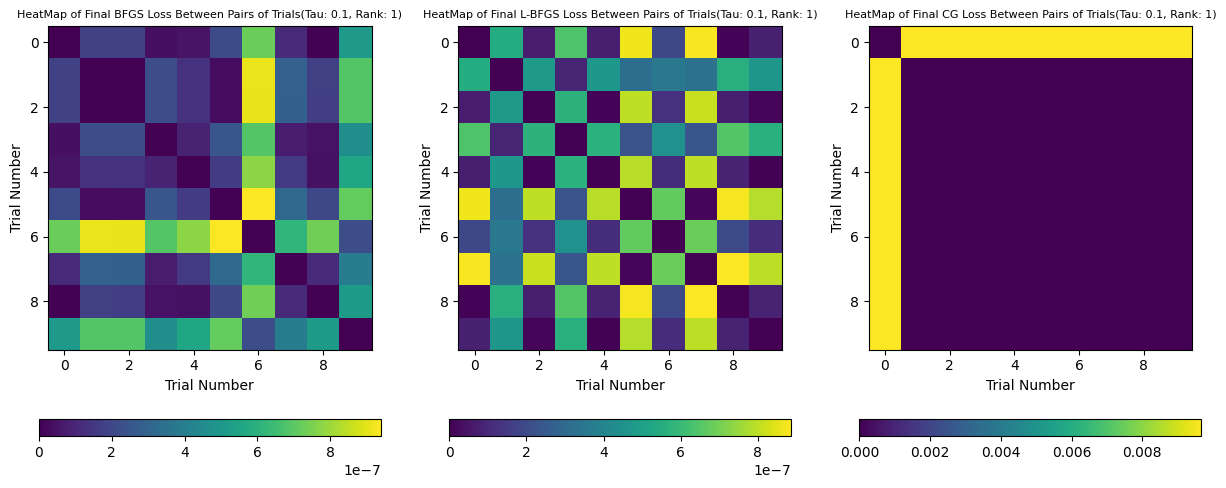

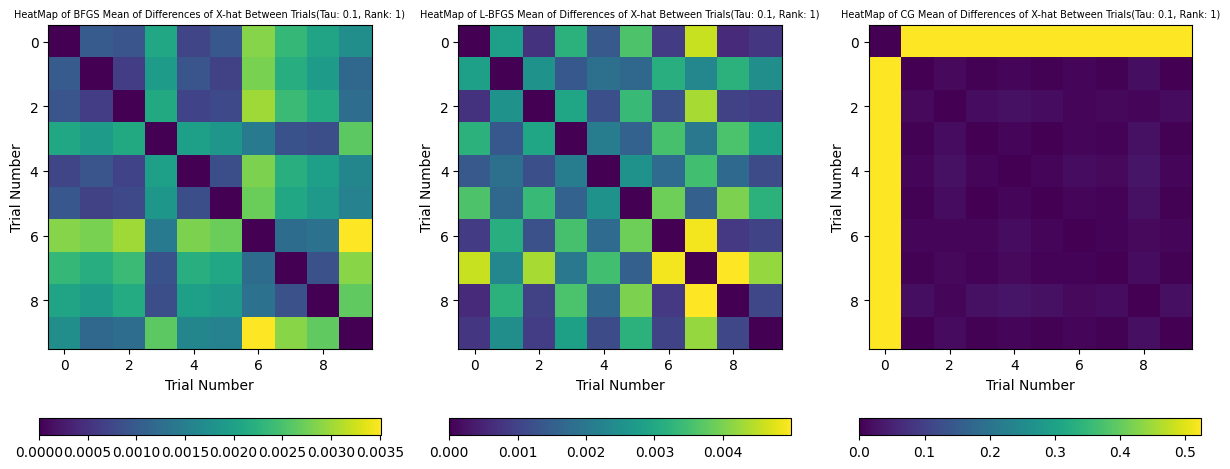

In [ ]:
# First Setup HeatMap
Plot_HeatMap(all_bfgs_final_loss_1, all_lbfgs_final_loss_1, all_cg_final_loss_1, all_bfgs_predict_array_1, all_lbfgs_predict_array_1, all_cg_predict_array_1, tau_1, rank_1)

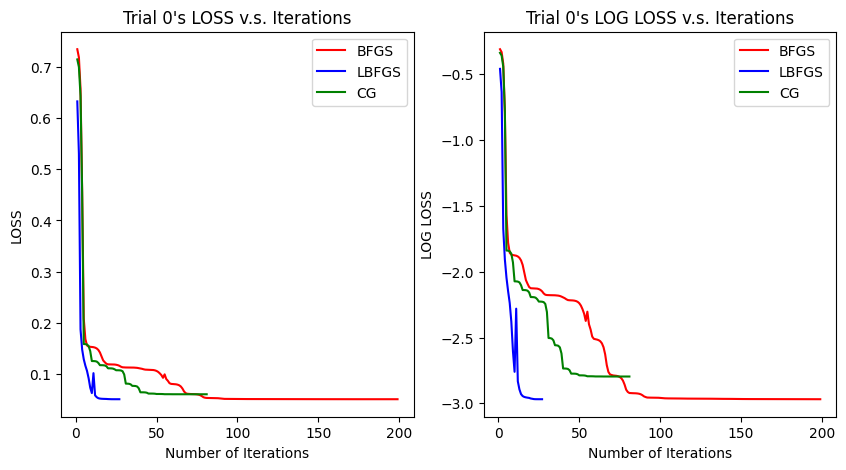

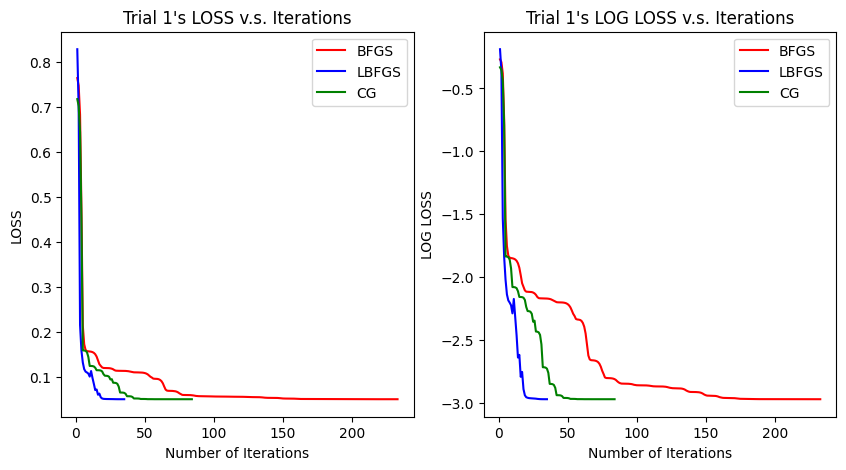

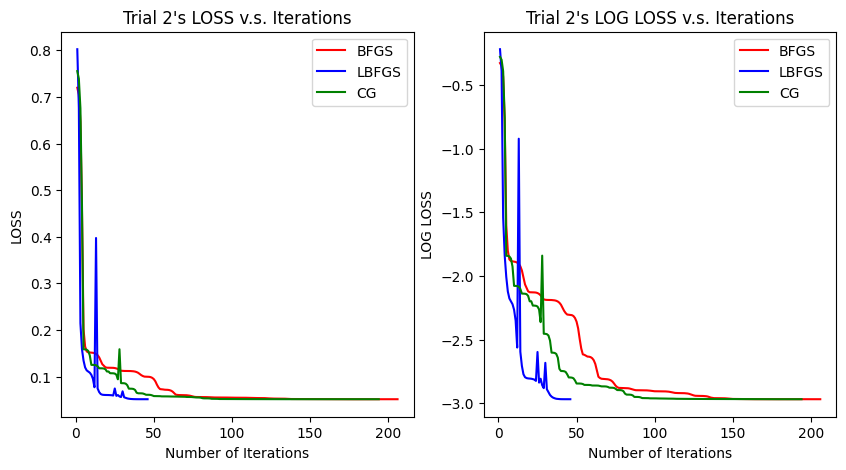

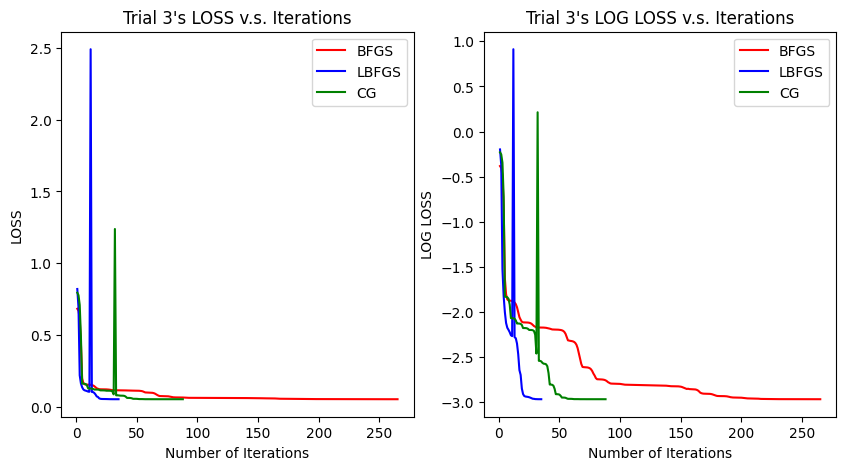

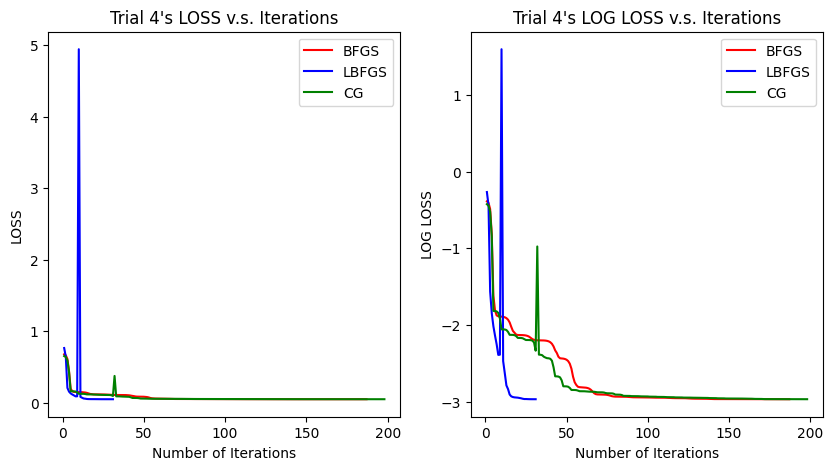

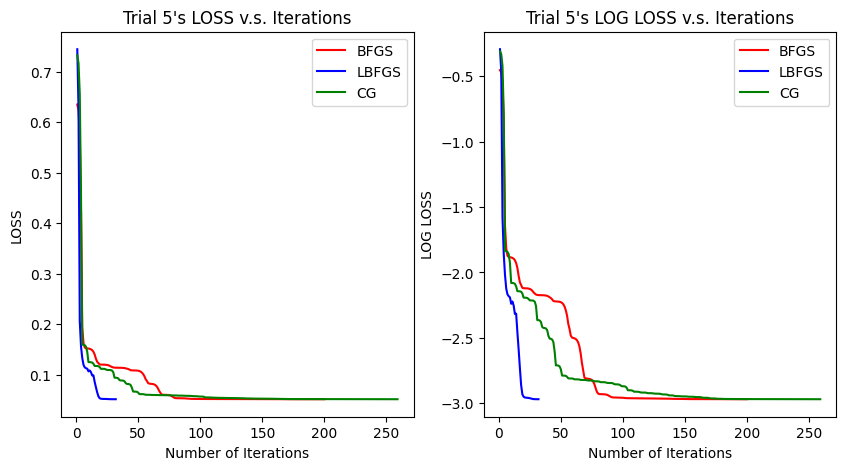

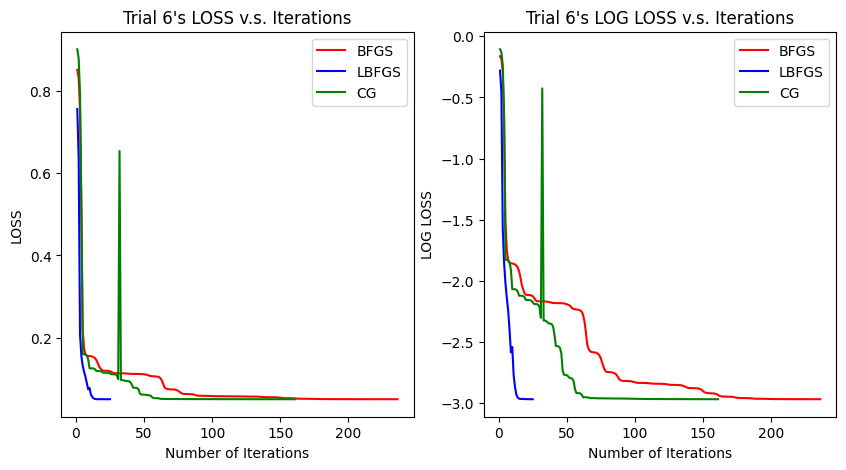

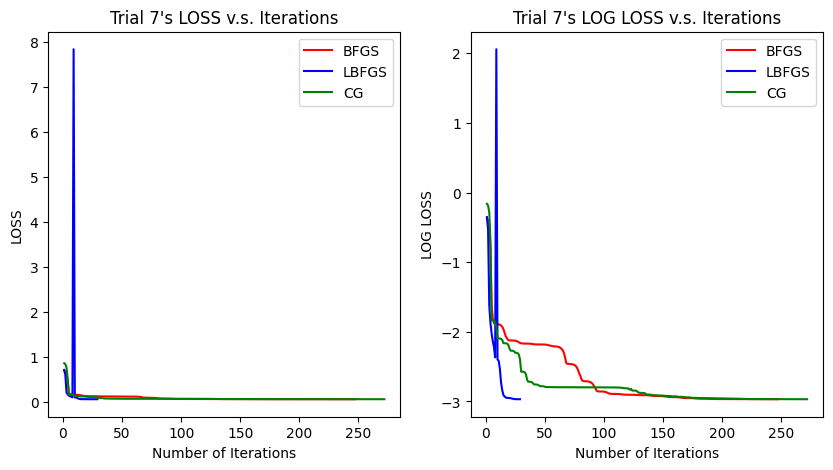

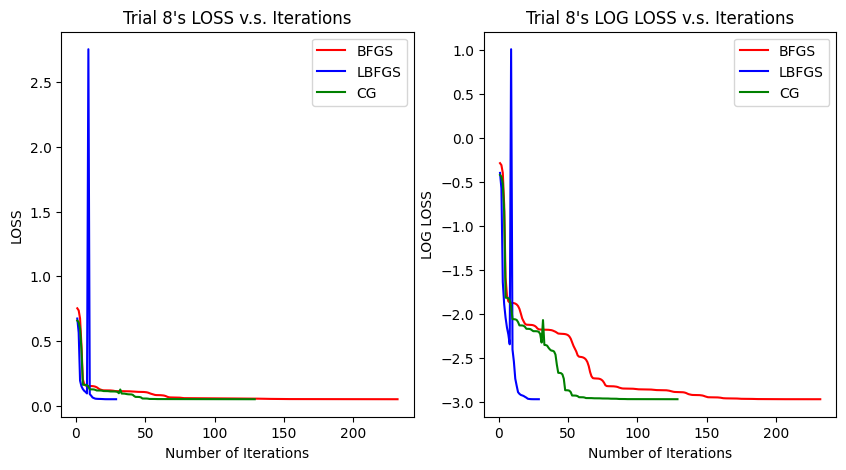

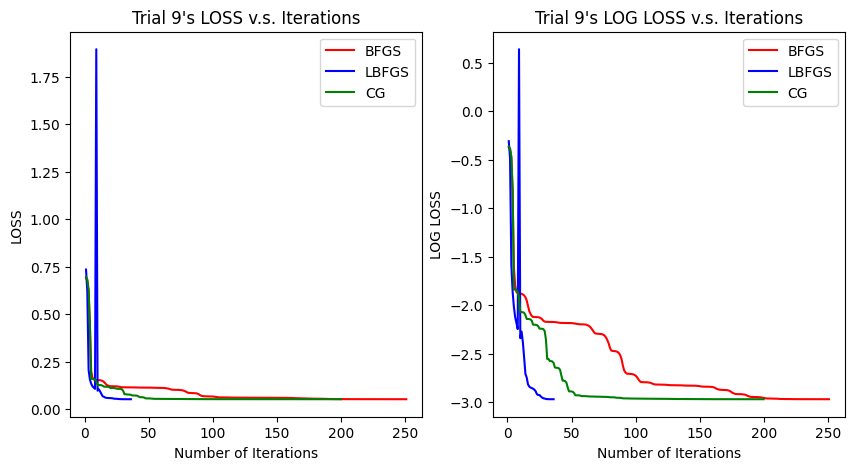

In [ ]:
# SETUP 1 Plot
for i in range(10):
  plotter(i, all_bfgs_loss_arrays_1[i], all_lbfgs_loss_arrays_1[i], all_cg_loss_arrays_1[i])

# Setup 2
Rank 2, Tau 0.1

In [ ]:
#-----------------
# Configuration 2:

# Matrix Size: 200 * 200
# True R SD: 1
# True C SD: 1
# True U/V Mean: 0
# True U/V STD: 1
# Sigma = 0.3
# Missing Proportion: 0.3
# Model Rank: 2
# Tau: 0.1
# Seed: 100
# R,C initialize with Row/Col mean
#-----------------
rank_2 = 2
tau_2 = 0.1
mu_2 = 0
sd_2 = 1
all_bfgs_loss_arrays_2, all_lbfgs_loss_arrays_2, all_cg_loss_arrays_2, all_bfgs_final_loss_2, all_lbfgs_final_loss_2, all_cg_final_loss_2, all_bfgs_predict_array_2, all_lbfgs_predict_array_2, all_cg_predict_array_2 = run_algorithm_ten_trials_sep_init(X_normalized_sq, rank_2, tau_2, row_mean_sq, col_mean_sq, mu_2, sd_2)

BFGS Final Loss: 0.004930337106074766
SETUP 0 BFGS Takes about:  40.85852122306824  (s)
SETUP 0 BFGS Iterations:  141
------------------------------------
L-BFGS-B Final Loss: 0.004929548860028632
SETUP 0 LBFGS Takes about:  0.07536935806274414  (s)
SETUP 0 LBFGS Iterations:  30
------------------------------------
CG Final Loss: 0.004929682009023332
Trial 0 CG Takes about:  0.2192373275756836  (s)
Trial 0 CG Iterations:  120

BFGS Final Loss: 0.004930030068793575
SETUP 1 BFGS Takes about:  53.50990152359009  (s)
SETUP 1 BFGS Iterations:  188
------------------------------------
L-BFGS-B Final Loss: 0.004929431228366946
SETUP 1 LBFGS Takes about:  0.06737136840820312  (s)
SETUP 1 LBFGS Iterations:  27
------------------------------------
CG Final Loss: 0.004929766386844271
Trial 1 CG Takes about:  0.18732070922851562  (s)
Trial 1 CG Iterations:  109

BFGS Final Loss: 0.00493057275248071
SETUP 2 BFGS Takes about:  47.2741334438324  (s)
SETUP 2 BFGS Iterations:  161
---------------------

In [ ]:
# Second Setup HeatMap
Plot_HeatMap(all_bfgs_final_loss_2, all_lbfgs_final_loss_2, all_cg_final_loss_2, all_bfgs_predict_array_2, all_lbfgs_predict_array_2, all_cg_predict_array_2, tau_2, rank_2)

NameError: name 'all_bfgs_final_loss_2' is not defined

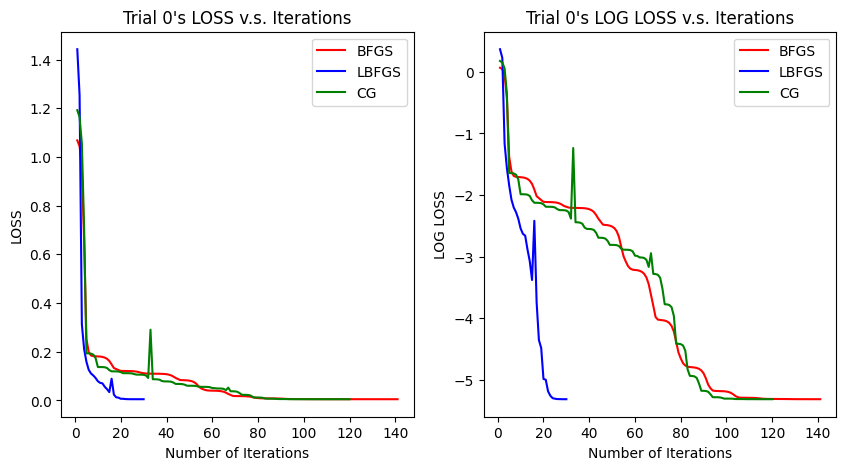

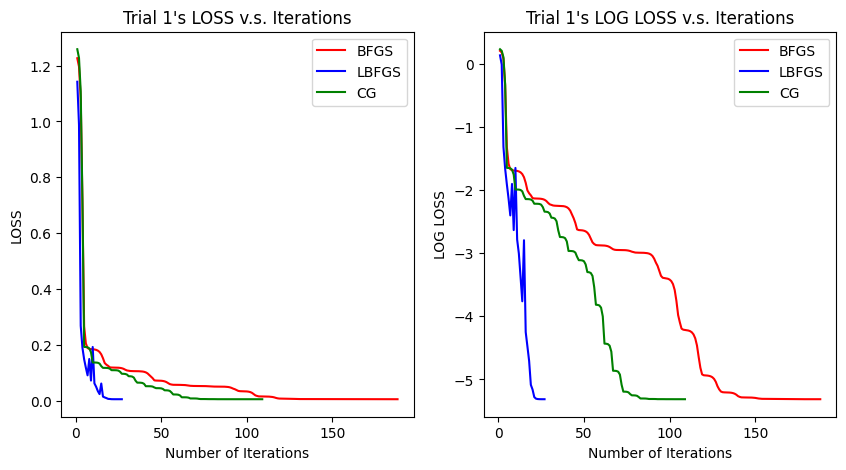

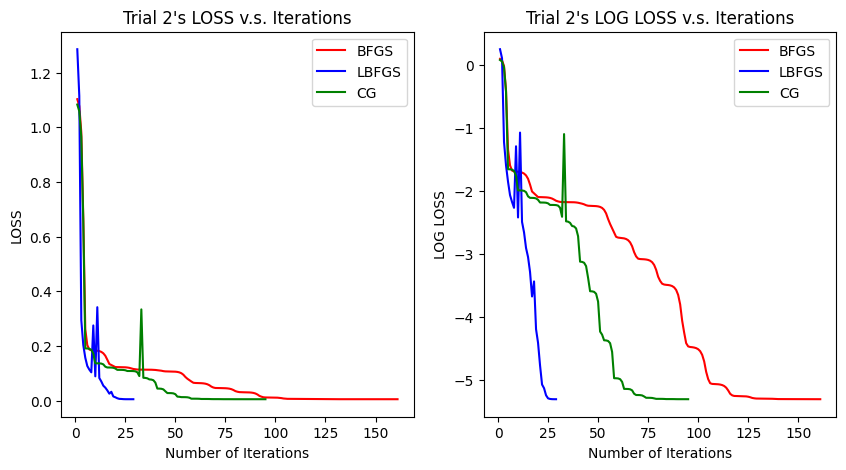

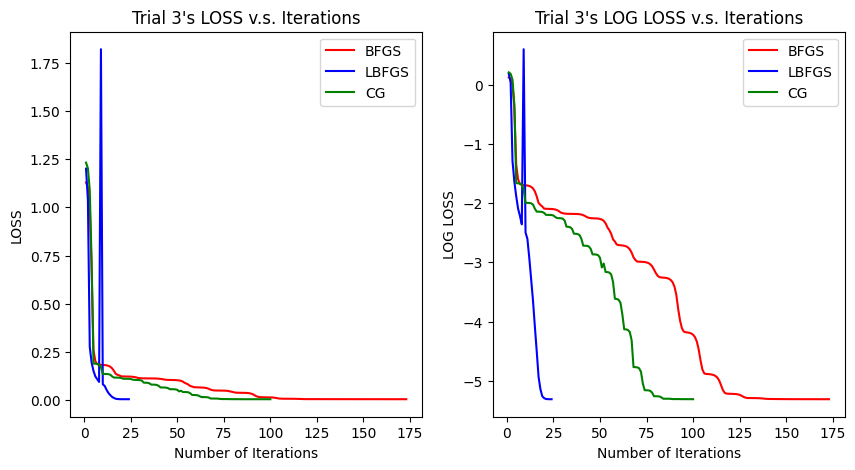

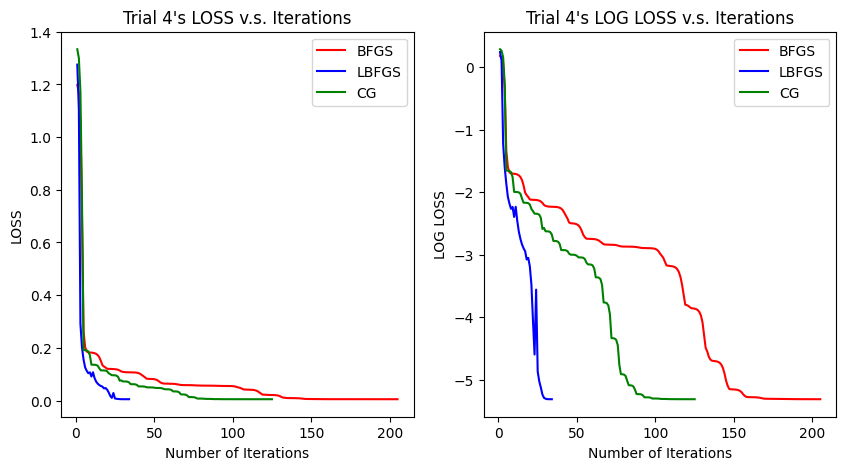

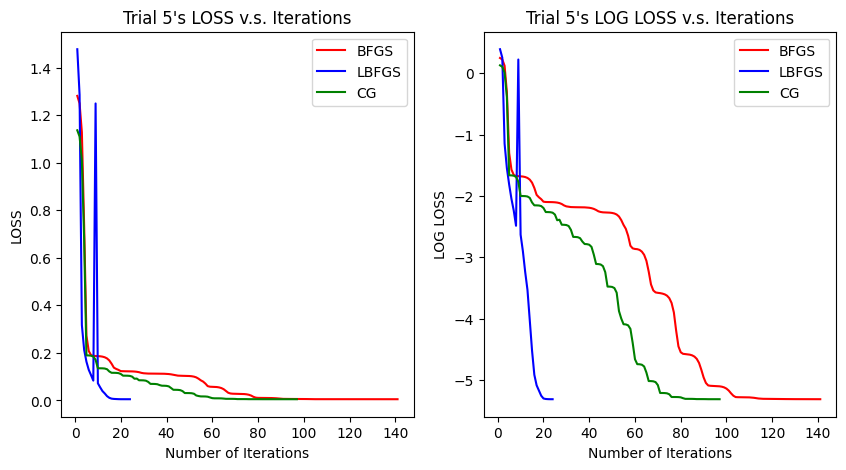

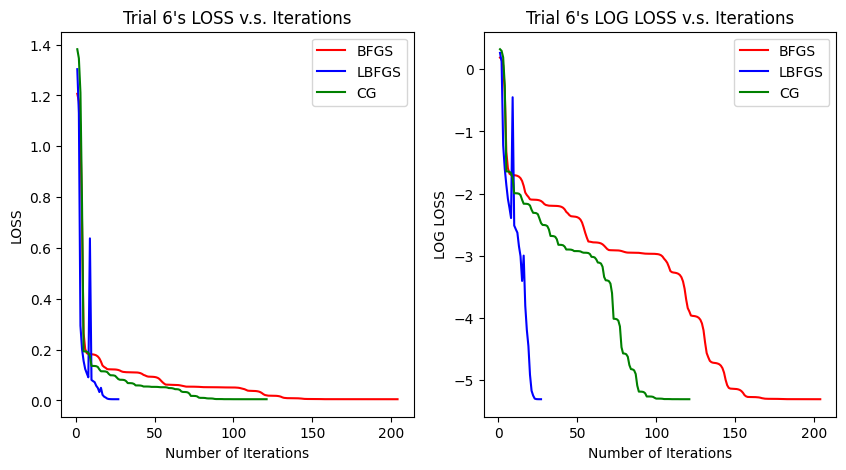

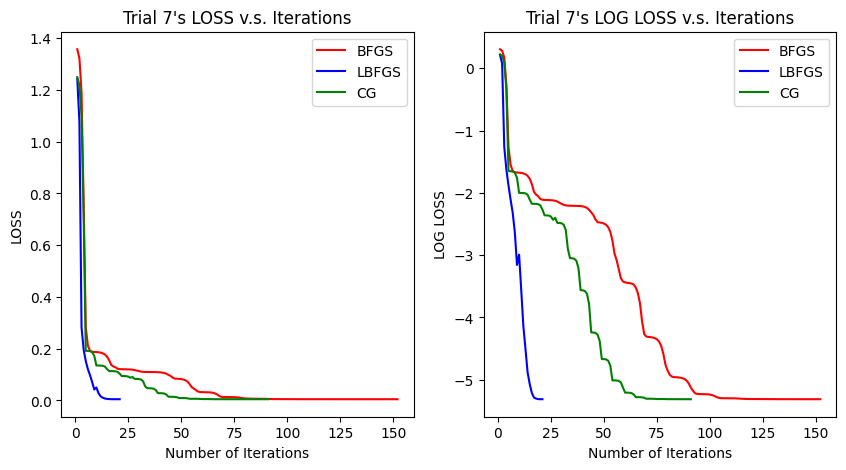

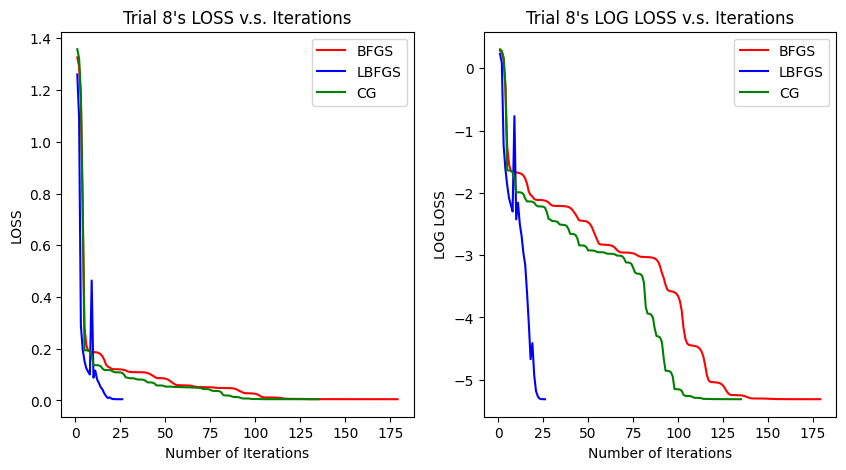

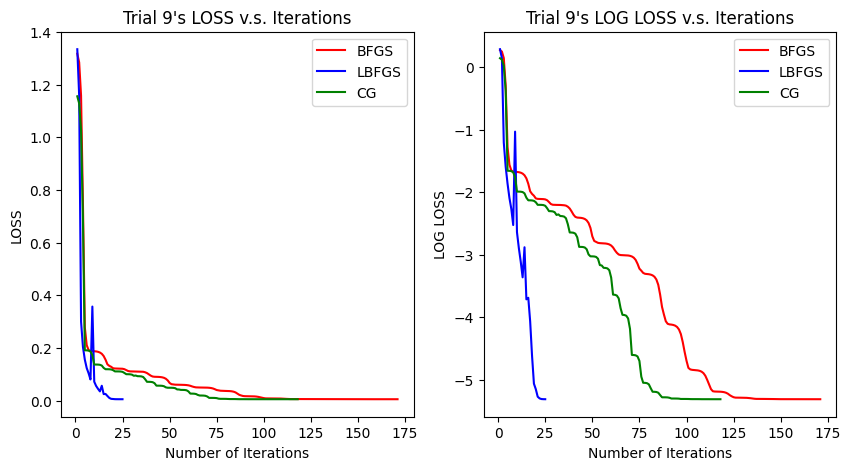

In [ ]:
# SETUP 2 Plot
for i in range(10):
  plotter(i, all_bfgs_loss_arrays_2[i], all_lbfgs_loss_arrays_2[i], all_cg_loss_arrays_2[i])

# Setup 3
Rank 2, Tau 0.3

In [12]:
regenerate_data_and_run_trials(100, 50)

BFGS Final Loss: 0.008773649727181495
L-BFGS-B Final Loss: 0.00877367595215115
CG Final Loss: 0.008774125137787869
BFGS Final Loss: 0.00877406147573626
L-BFGS-B Final Loss: 0.00877360428493384
CG Final Loss: 0.008773670396090496
BFGS Final Loss: 0.008774015464403307
L-BFGS-B Final Loss: 0.008773714549348562
CG Final Loss: 0.008773583428450407
BFGS Final Loss: 0.008774350735189585
L-BFGS-B Final Loss: 0.008773711451343584
CG Final Loss: 0.008773504784946897
BFGS Final Loss: 0.008773680008142456
L-BFGS-B Final Loss: 0.00877354876299862
CG Final Loss: 0.008774601044177334
BFGS Final Loss: 0.008774126653809368
L-BFGS-B Final Loss: 0.008774050000788555
CG Final Loss: 0.008773665699501325
BFGS Final Loss: 0.008773682823791465
L-BFGS-B Final Loss: 0.008773474311922167
CG Final Loss: 0.008773923445873636
BFGS Final Loss: 0.00877385097955815
L-BFGS-B Final Loss: 0.008773832607011091
CG Final Loss: 0.00877353207517031
BFGS Final Loss: 0.008773563406435262
L-BFGS-B Final Loss: 0.00877359664136522

KeyboardInterrupt: 

In [ ]:
#-----------------
# Configuration 3:

# Matrix Size: 200 * 200
# True R SD: 1
# True C SD: 1
# True U/V Mean: 0
# True U/V STD: 1
# Sigma = 0.3
# Missing Proportion: 0.3
# Model Rank: 2
# Tau: 0.3
# Seed: 100
# R,C initialize with Row/Col mean
#-----------------
rank_3 = 2
tau_3 = 0.3
mu_3 = 0
sd_3 = 1
all_bfgs_loss_arrays_3, all_lbfgs_loss_arrays_3, all_cg_loss_arrays_3, all_bfgs_final_loss_3, all_lbfgs_final_loss_3, all_cg_final_loss_3, all_bfgs_predict_array_3, all_lbfgs_predict_array_3, all_cg_predict_array_3 = run_algorithm_ten_trials_sep_init(X_normalized_sq, rank_3, tau_3, row_mean_sq, col_mean_sq, mu_3, sd_3)

BFGS Final Loss: 0.008773649727181495
SETUP 0 BFGS Takes about:  36.726564168930054  (s)
SETUP 0 BFGS Iterations:  127
------------------------------------
L-BFGS-B Final Loss: 0.00877367595215115
SETUP 0 LBFGS Takes about:  0.07479405403137207  (s)
SETUP 0 LBFGS Iterations:  28
------------------------------------
CG Final Loss: 0.008774125137787869
Trial 0 CG Takes about:  0.14564967155456543  (s)
Trial 0 CG Iterations:  77

BFGS Final Loss: 0.00877406147573626
SETUP 1 BFGS Takes about:  35.31337022781372  (s)
SETUP 1 BFGS Iterations:  128
------------------------------------
L-BFGS-B Final Loss: 0.00877360428493384
SETUP 1 LBFGS Takes about:  0.06816482543945312  (s)
SETUP 1 LBFGS Iterations:  24
------------------------------------
CG Final Loss: 0.008773670396090496
Trial 1 CG Takes about:  0.1773676872253418  (s)
Trial 1 CG Iterations:  85

BFGS Final Loss: 0.008774015464403307
SETUP 2 BFGS Takes about:  40.21339297294617  (s)
SETUP 2 BFGS Iterations:  143
-----------------------

In [ ]:
# X_hat = R_1[:, np.newaxis] + C_1 + U_1 @ V_1.T
# X_hat

# X_hat_l = l_R_1[:, np.newaxis] + l_C_1 + l_U_1 @ l_V_1.T
# #print(list(X_hat_l))

# # print(X_hat)
# # print(X_hat_l)
# print(np.sqrt(np.mean((X_hat - X_hat_l)**2)))
# diff = X_hat - X_hat_l
# masked = np.isnan(X_config1)
# X_hat = X_hat[~masked]
# plt.hist(diff.ravel().flat)

# X_hat_l = X_hat_l[~masked]

# plt.plot(X_hat_l.ravel(), lbfgs_new.ravel(), "o")
# plt.plot(X_hat.ravel(), X_new.ravel(), "o")

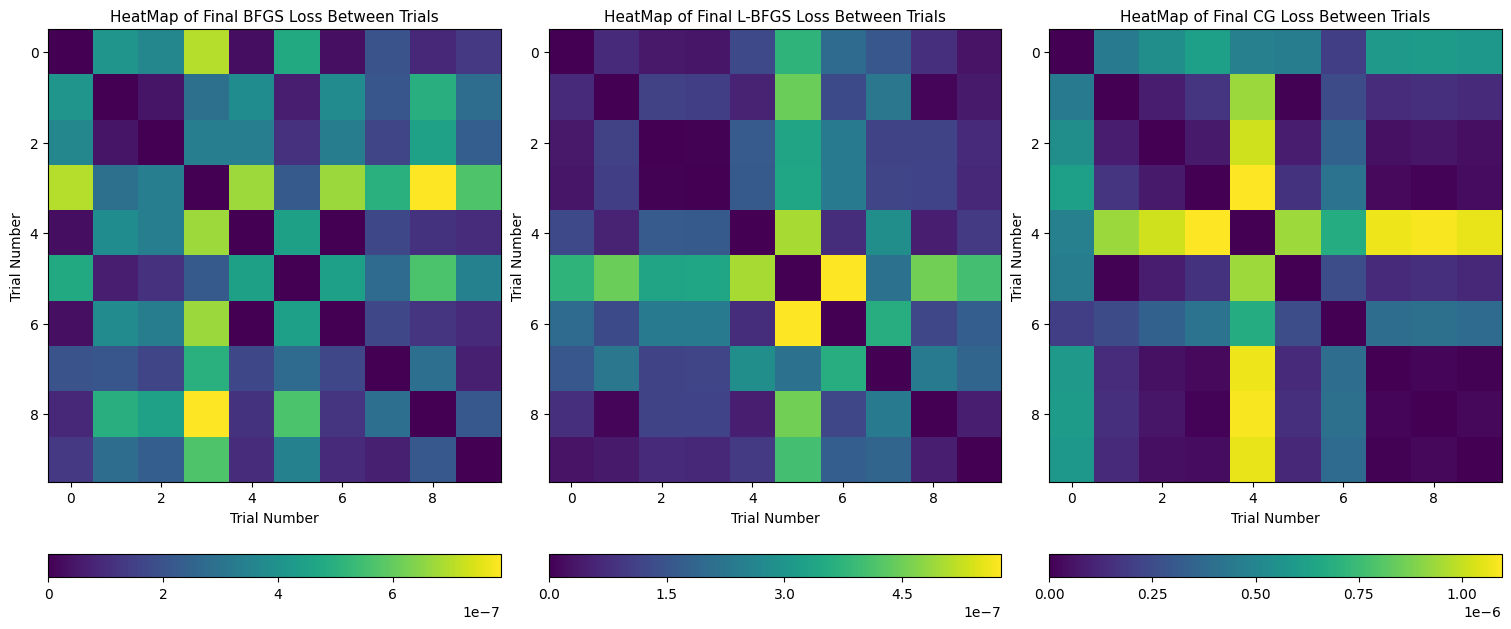

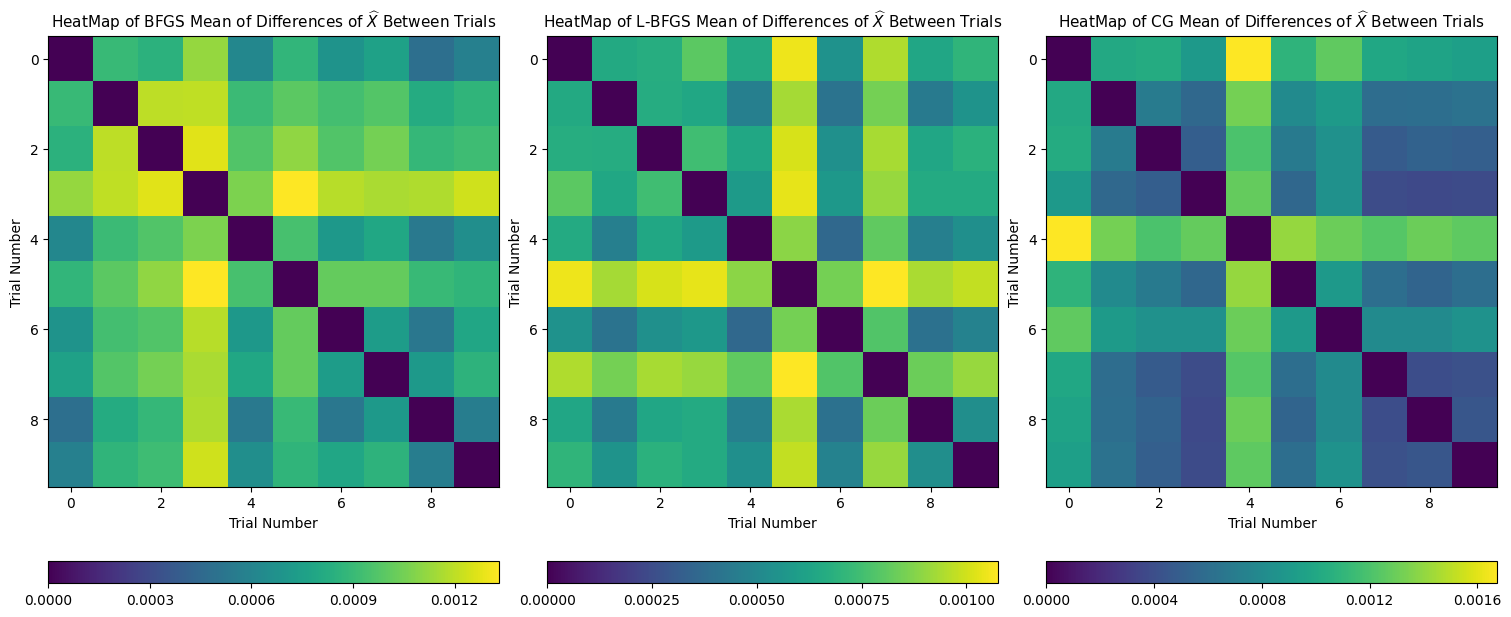

In [ ]:
# Third Setup HeatMap
Plot_HeatMap(all_bfgs_final_loss_3, all_lbfgs_final_loss_3, all_cg_final_loss_3, all_bfgs_predict_array_3, all_lbfgs_predict_array_3, all_cg_predict_array_3, tau_3, rank_3)

<Figure size 640x480 with 0 Axes>

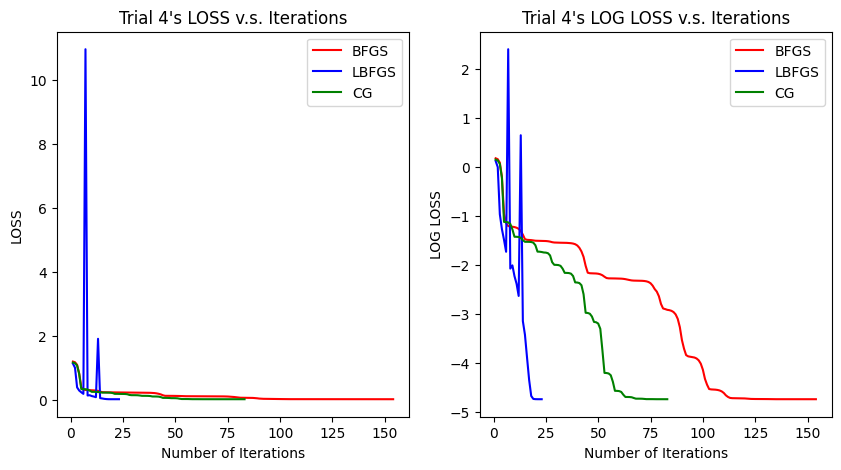

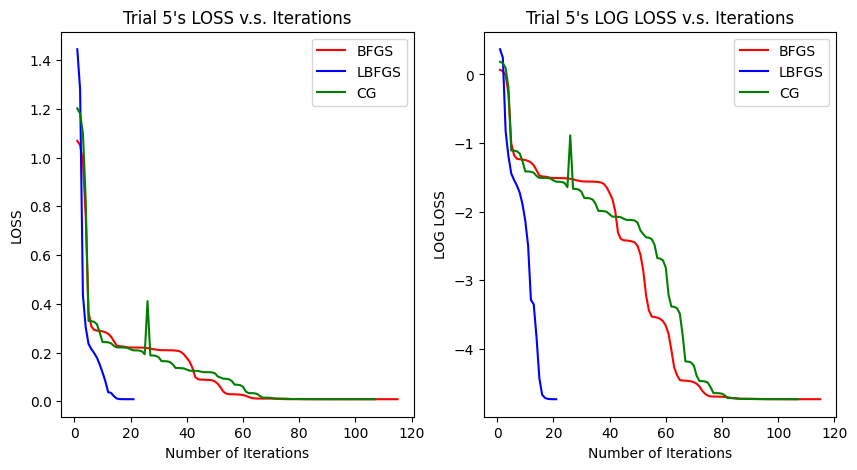

In [ ]:
# SETUP 3 Plot
# for i in range(10):
#   plotter(i, all_bfgs_loss_arrays_3[i], all_lbfgs_loss_arrays_3[i], all_cg_loss_arrays_3[i])
plt.figure()
plotter(4, all_bfgs_loss_arrays_3[4], all_lbfgs_loss_arrays_3[4], all_cg_loss_arrays_3[4])
plotter(5, all_bfgs_loss_arrays_3[5], all_lbfgs_loss_arrays_3[5], all_cg_loss_arrays_3[5])
plt.savefig("lossfigure.pdf")

# Setup 4
Rank 2, Tau 0.5

In [ ]:
#-----------------
# Configuration 4:

# Matrix Size: 200 * 200
# True R SD: 1
# True C SD: 1
# True U/V Mean: 0
# True U/V STD: 1
# Sigma = 0.3
# Missing Proportion: 0.3
# Model Rank: 2
# Tau: 0.5
# Seed: 100
# R,C initialize with Row/Col mean
#-----------------
rank_4 = 2
tau_4 = 0.5
mu_4 = 0
sd_4 = 1
all_bfgs_loss_arrays_4, all_lbfgs_loss_arrays_4, all_cg_loss_arrays_4, all_bfgs_final_loss_4, all_lbfgs_final_loss_4, all_cg_final_loss_4, all_bfgs_predict_array_4, all_lbfgs_predict_array_4, all_cg_predict_array_4 = run_algorithm_ten_trials_sep_init(X_normalized_sq, rank_4, tau_4, row_mean_sq, col_mean_sq, mu_4, sd_4)

BFGS Final Loss: 0.00981862748429363
SETUP 0 BFGS Takes about:  33.096712589263916  (s)
SETUP 0 BFGS Iterations:  120
------------------------------------
L-BFGS-B Final Loss: 0.009818504843642155
SETUP 0 LBFGS Takes about:  0.05749082565307617  (s)
SETUP 0 LBFGS Iterations:  22
------------------------------------
CG Final Loss: 0.00981860611123281
Trial 0 CG Takes about:  0.1519787311553955  (s)
Trial 0 CG Iterations:  77

BFGS Final Loss: 0.009818763845159924
SETUP 1 BFGS Takes about:  33.41725492477417  (s)
SETUP 1 BFGS Iterations:  119
------------------------------------
L-BFGS-B Final Loss: 0.009818585666072485
SETUP 1 LBFGS Takes about:  0.09445953369140625  (s)
SETUP 1 LBFGS Iterations:  36
------------------------------------
CG Final Loss: 0.009818829861585186
Trial 1 CG Takes about:  0.1543593406677246  (s)
Trial 1 CG Iterations:  77

BFGS Final Loss: 0.009818973140176806
SETUP 2 BFGS Takes about:  31.870201110839844  (s)
SETUP 2 BFGS Iterations:  121
----------------------

In [ ]:
# Fourth Setup HeatMap
Plot_HeatMap(all_bfgs_final_loss_4, all_lbfgs_final_loss_4, all_cg_final_loss_4, all_bfgs_predict_array_4, all_lbfgs_predict_array_4, all_cg_predict_array_4, tau_4, rank_4)

NameError: name 'all_bfgs_final_loss_4' is not defined

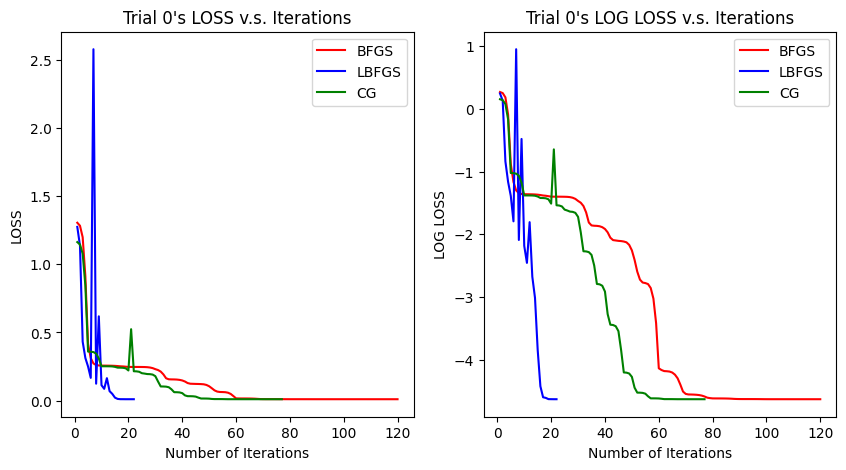

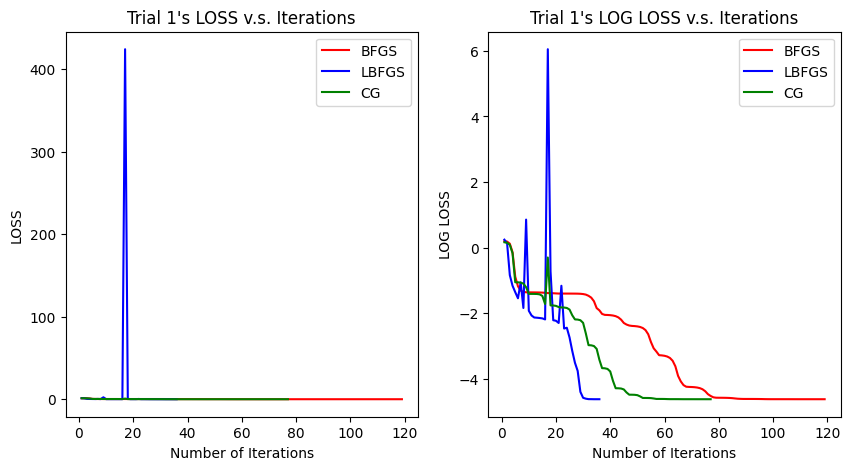

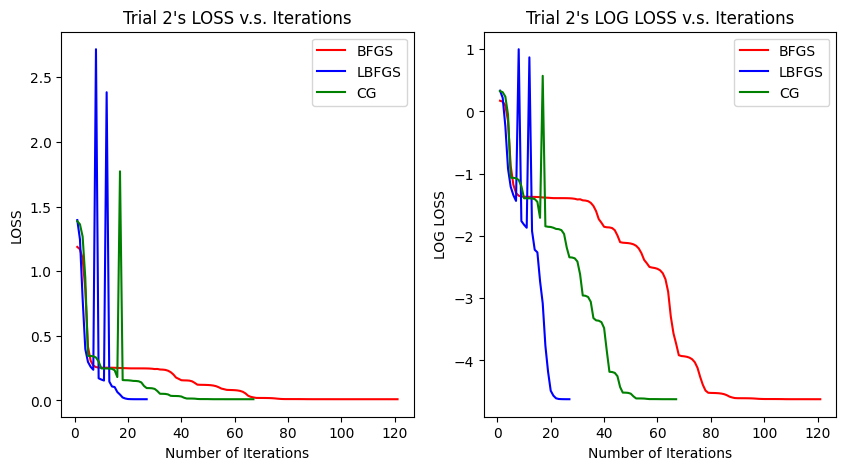

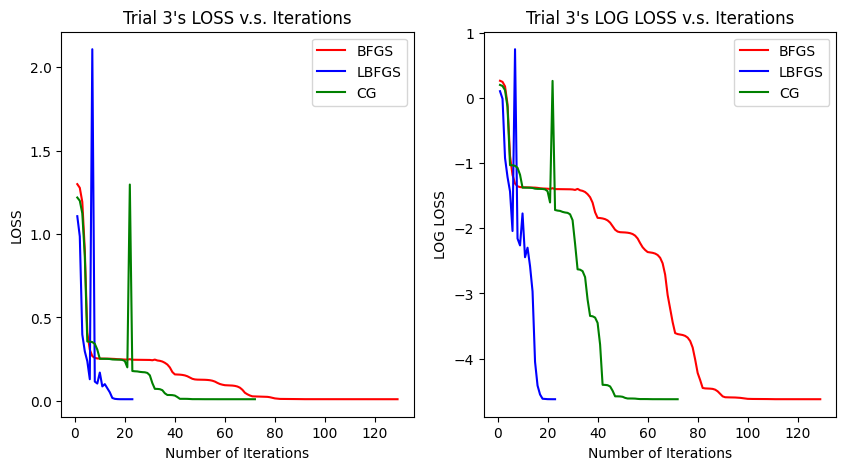

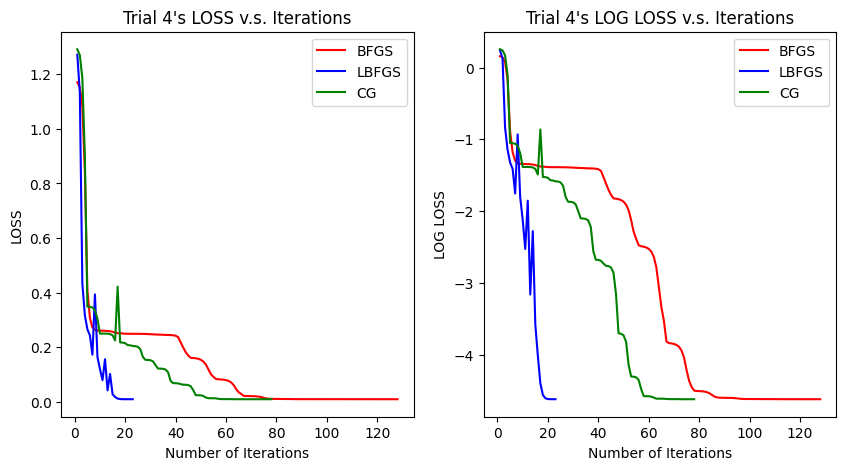

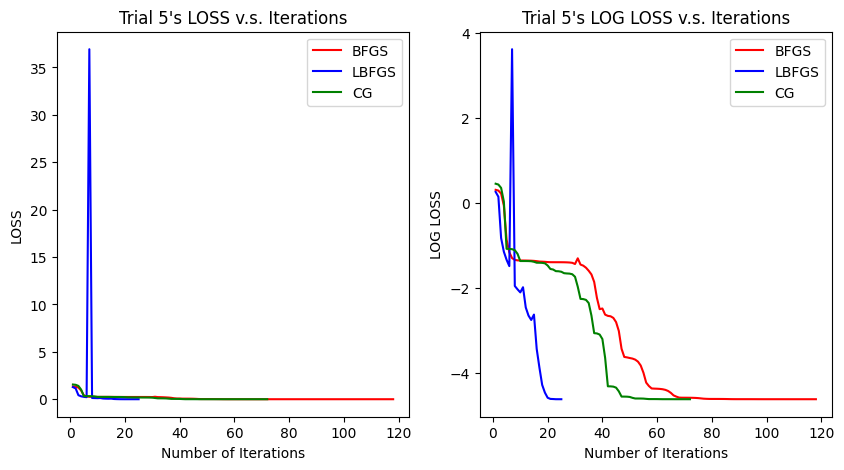

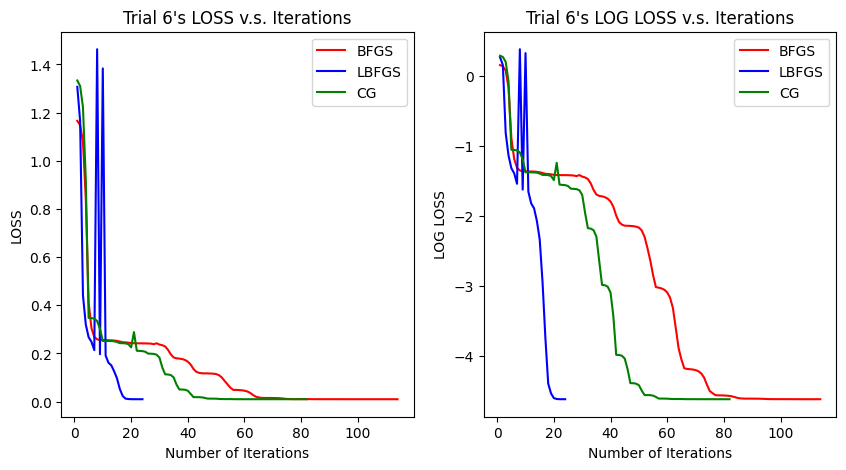

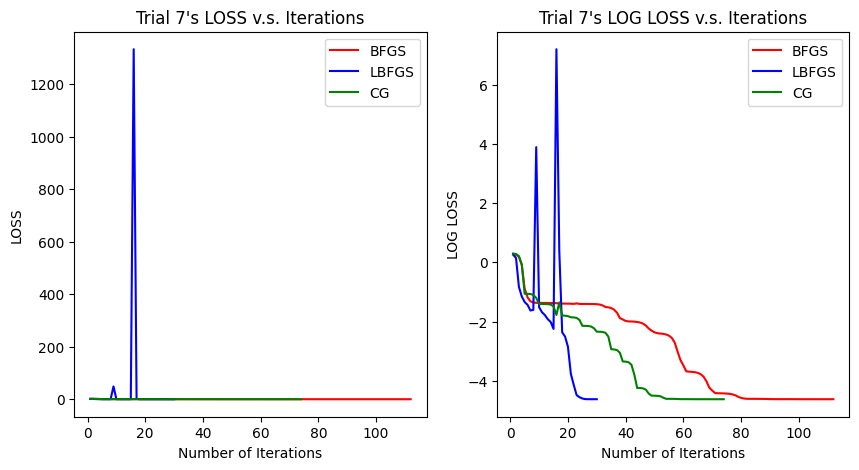

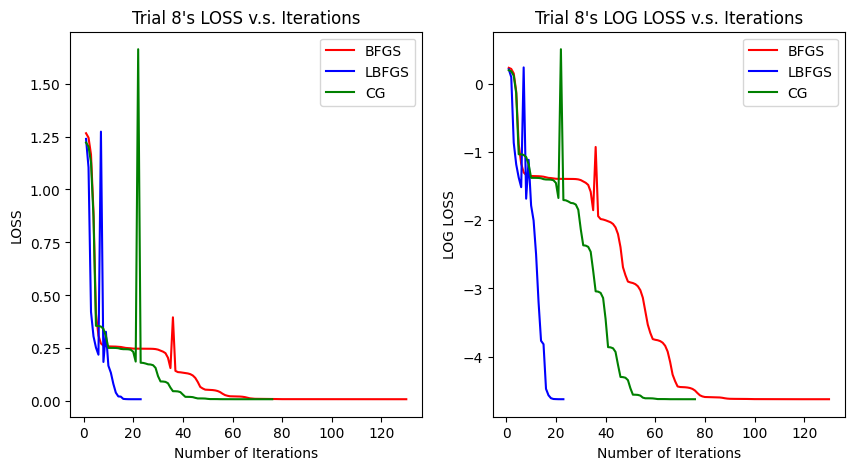

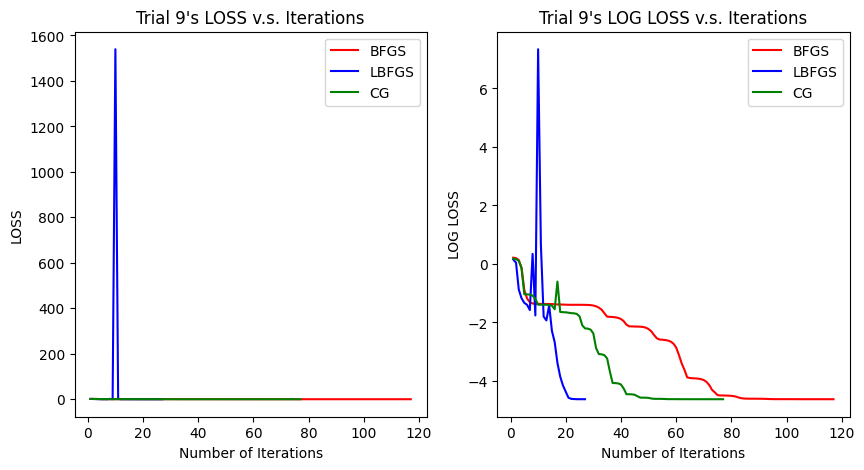

In [ ]:
# SETUP 4 Plot
for i in range(10):
  plotter(i, all_bfgs_loss_arrays_4[i], all_lbfgs_loss_arrays_4[i], all_cg_loss_arrays_4[i])

# Setup 5
Rank 2, Tau 0.7

In [ ]:
#-----------------
# Configuration 5:

# Matrix Size: 200 * 200
# True R SD: 1
# True C SD: 1
# True U/V Mean: 0
# True U/V STD: 1
# Sigma = 0.3
# Missing Proportion: 0.3
# Model Rank: 2
# Tau: 0.7
# Seed: 100
# R,C initialize with Row/Col mean
#-----------------
rank_5 = 2
tau_5 = 0.7
mu_5 = 0
sd_5 = 1
all_bfgs_loss_arrays_5, all_lbfgs_loss_arrays_5, all_cg_loss_arrays_5, all_bfgs_final_loss_5, all_lbfgs_final_loss_5, all_cg_final_loss_5, all_bfgs_predict_array_5, all_lbfgs_predict_array_5, all_cg_predict_array_5 = run_algorithm_ten_trials_sep_init(X_normalized_sq, rank_5, tau_5, row_mean_sq, col_mean_sq, mu_5, sd_5)

BFGS Final Loss: 0.008728619339532366
SETUP 0 BFGS Takes about:  42.080650329589844  (s)
SETUP 0 BFGS Iterations:  155
------------------------------------
L-BFGS-B Final Loss: 0.008728899929491224
SETUP 0 LBFGS Takes about:  0.06303620338439941  (s)
SETUP 0 LBFGS Iterations:  24
------------------------------------
CG Final Loss: 0.008728713416805374
Trial 0 CG Takes about:  0.18218255043029785  (s)
Trial 0 CG Iterations:  93

BFGS Final Loss: 0.008728589784568482
SETUP 1 BFGS Takes about:  42.34928822517395  (s)
SETUP 1 BFGS Iterations:  146
------------------------------------
L-BFGS-B Final Loss: 0.008728745814955323
SETUP 1 LBFGS Takes about:  0.06024789810180664  (s)
SETUP 1 LBFGS Iterations:  21
------------------------------------
CG Final Loss: 0.008728550420045436
Trial 1 CG Takes about:  0.24265146255493164  (s)
Trial 1 CG Iterations:  123

BFGS Final Loss: 0.008728596195661891
SETUP 2 BFGS Takes about:  33.37595057487488  (s)
SETUP 2 BFGS Iterations:  121
------------------

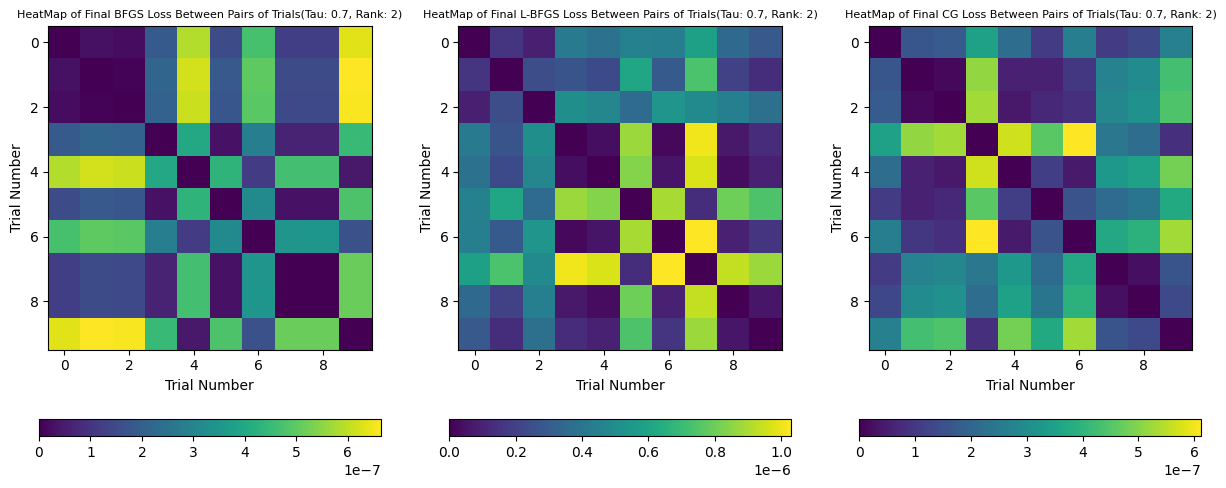

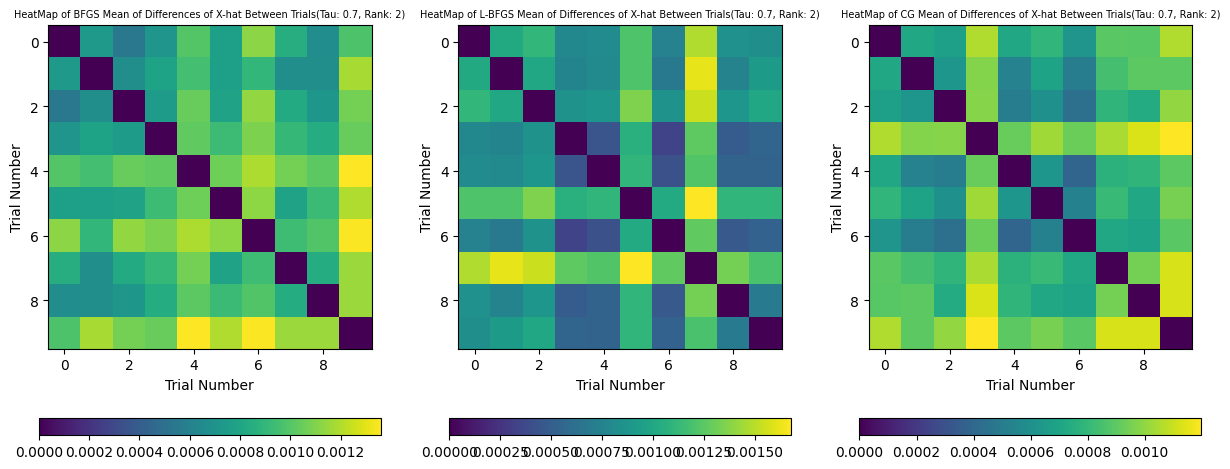

In [ ]:
# 5 Setup HeatMap
Plot_HeatMap(all_bfgs_final_loss_5, all_lbfgs_final_loss_5, all_cg_final_loss_5, all_bfgs_predict_array_5, all_lbfgs_predict_array_5, all_cg_predict_array_5, tau_5, rank_5)

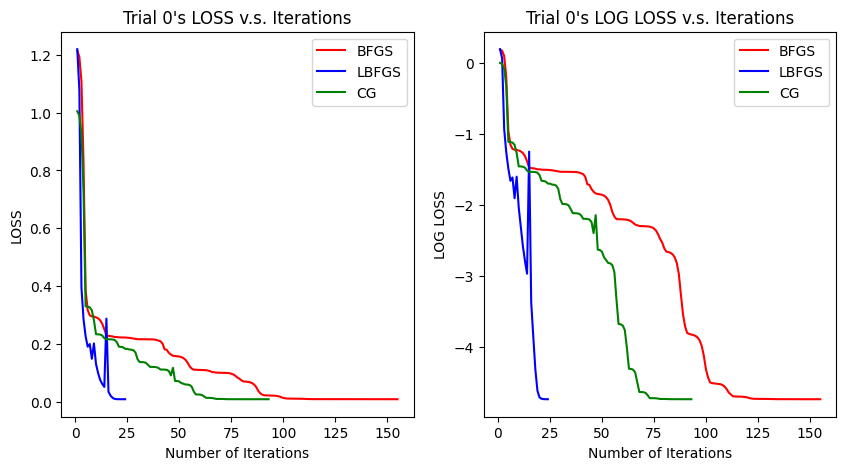

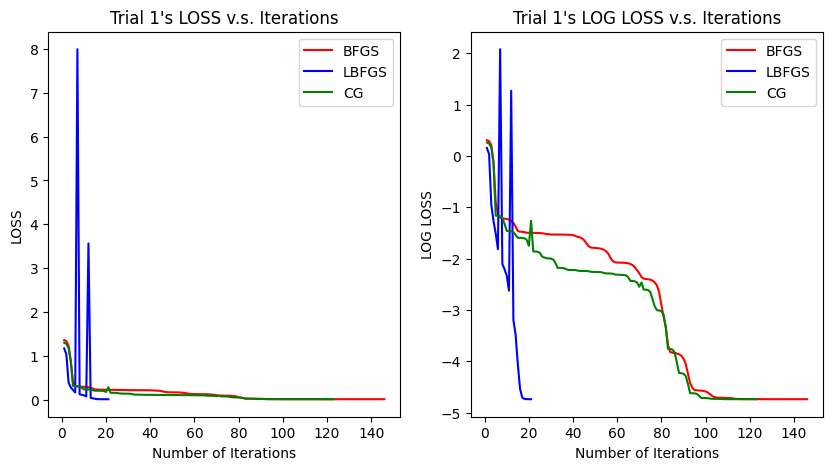

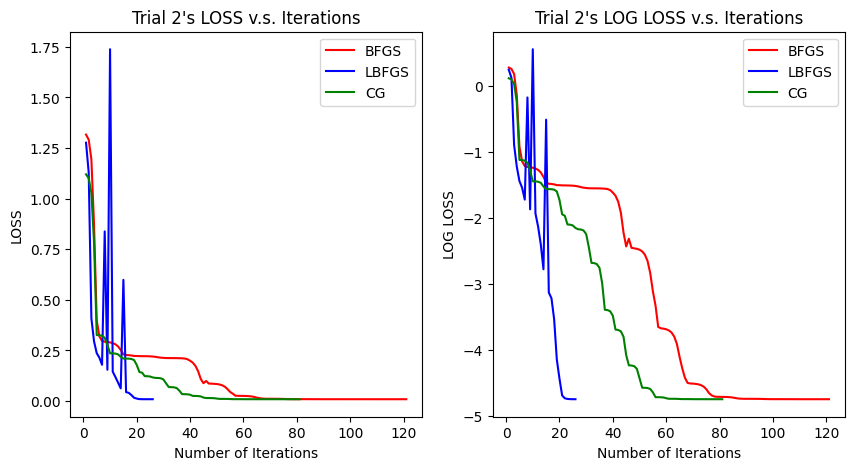

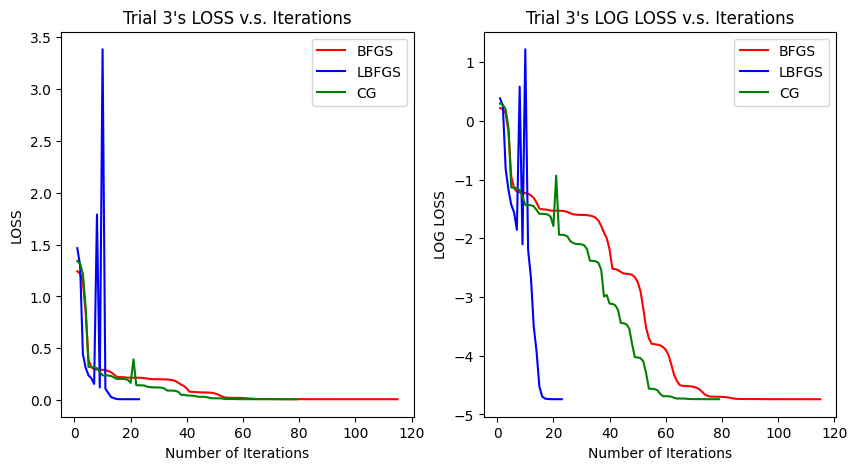

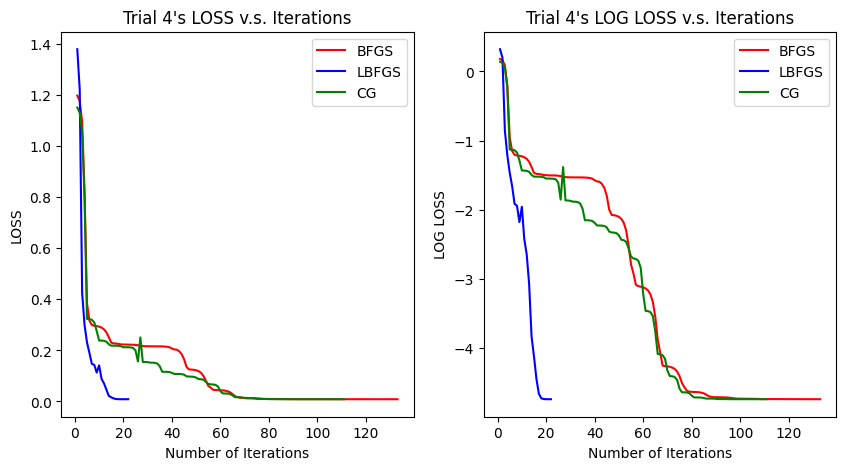

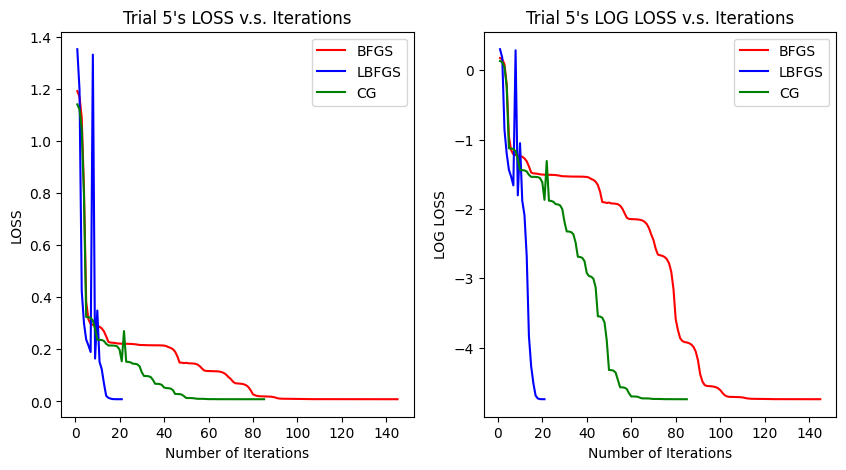

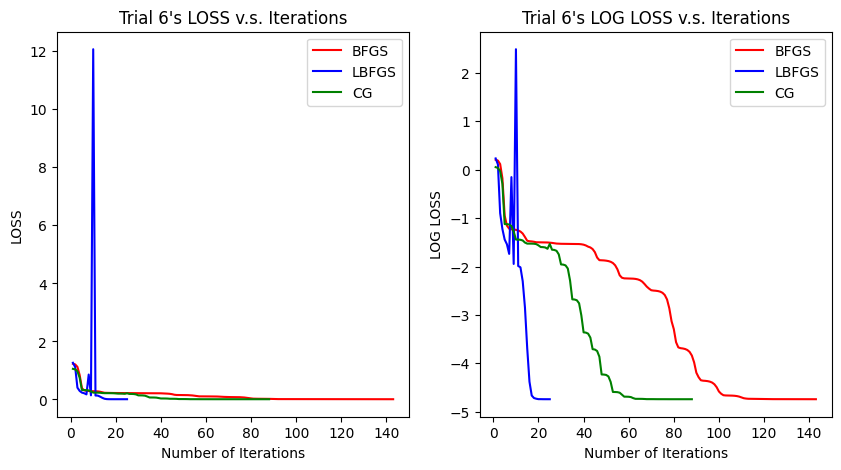

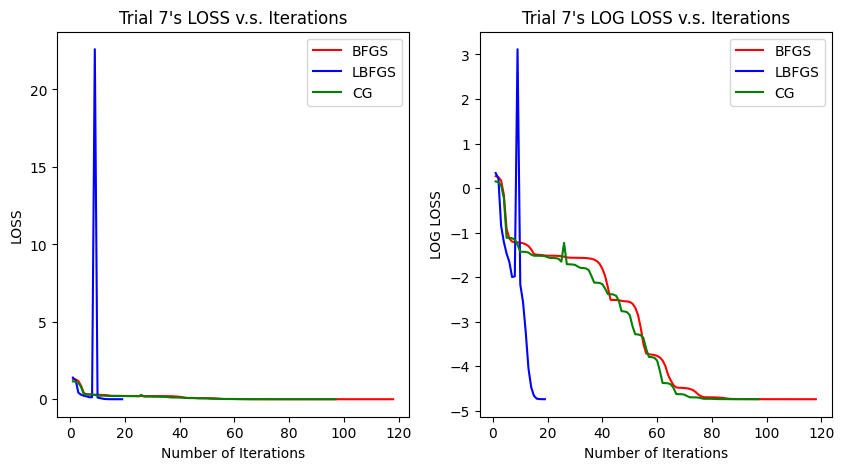

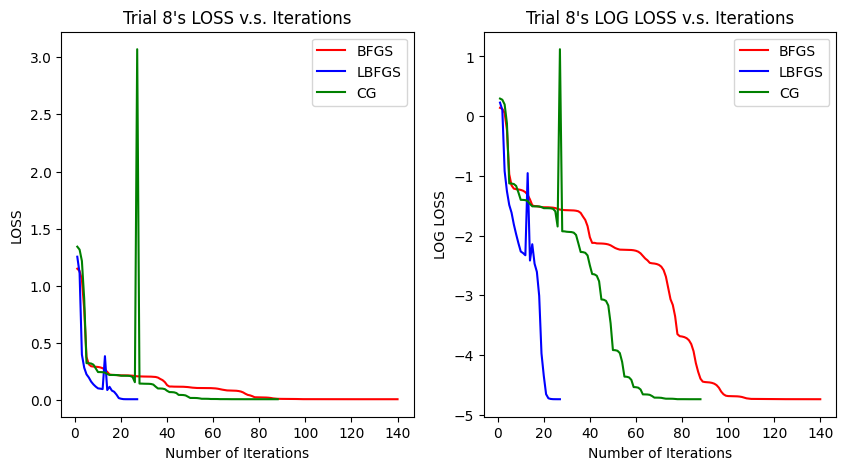

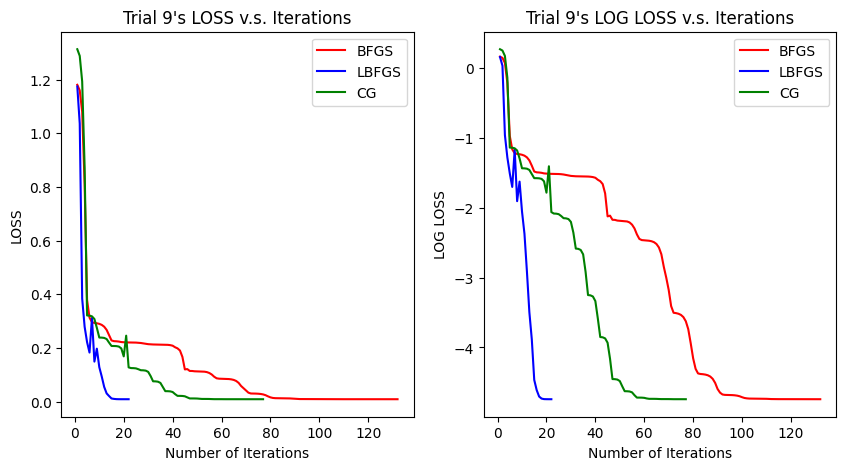

In [ ]:
# SETUP 5 Plot
for i in range(10):
  plotter(i, all_bfgs_loss_arrays_5[i], all_lbfgs_loss_arrays_5[i], all_cg_loss_arrays_5[i])

# Setup 6
Rank 2, Tau 0.9


In [ ]:
#-----------------
# Configuration 6:

# Matrix Size: 200 * 200
# True R SD: 1
# True C SD: 1
# True U/V Mean: 0
# True U/V STD: 1
# Sigma = 0.3
# Missing Proportion: 0.3
# Model Rank: 2
# Tau: 0.9
# Seed: 100
# R,C initialize with Row/Col mean
#-----------------
rank_6 = 2
tau_6 = 0.9
mu_6 = 0
sd_6 = 1
all_bfgs_loss_arrays_6, all_lbfgs_loss_arrays_6, all_cg_loss_arrays_6, all_bfgs_final_loss_6, all_lbfgs_final_loss_6, all_cg_final_loss_6, all_bfgs_predict_array_6, all_lbfgs_predict_array_6, all_cg_predict_array_6 = run_algorithm_ten_trials_sep_init(X_normalized_sq, rank_6, tau_6, row_mean_sq, col_mean_sq, mu_6, sd_6)

BFGS Final Loss: 0.004859284260858436
SETUP 0 BFGS Takes about:  41.44458866119385  (s)
SETUP 0 BFGS Iterations:  151
------------------------------------
L-BFGS-B Final Loss: 0.004859339396328657
SETUP 0 LBFGS Takes about:  0.06860518455505371  (s)
SETUP 0 LBFGS Iterations:  26
------------------------------------
CG Final Loss: 0.004859459447063907
Trial 0 CG Takes about:  0.1836395263671875  (s)
Trial 0 CG Iterations:  94

BFGS Final Loss: 0.0048595101608074984
SETUP 1 BFGS Takes about:  39.6302444934845  (s)
SETUP 1 BFGS Iterations:  140
------------------------------------
L-BFGS-B Final Loss: 0.004859022302015943
SETUP 1 LBFGS Takes about:  0.06273150444030762  (s)
SETUP 1 LBFGS Iterations:  25
------------------------------------
CG Final Loss: 0.0048590853945720365
Trial 1 CG Takes about:  0.18227458000183105  (s)
Trial 1 CG Iterations:  99

BFGS Final Loss: 0.004859359204312603
SETUP 2 BFGS Takes about:  37.85712766647339  (s)
SETUP 2 BFGS Iterations:  139
--------------------

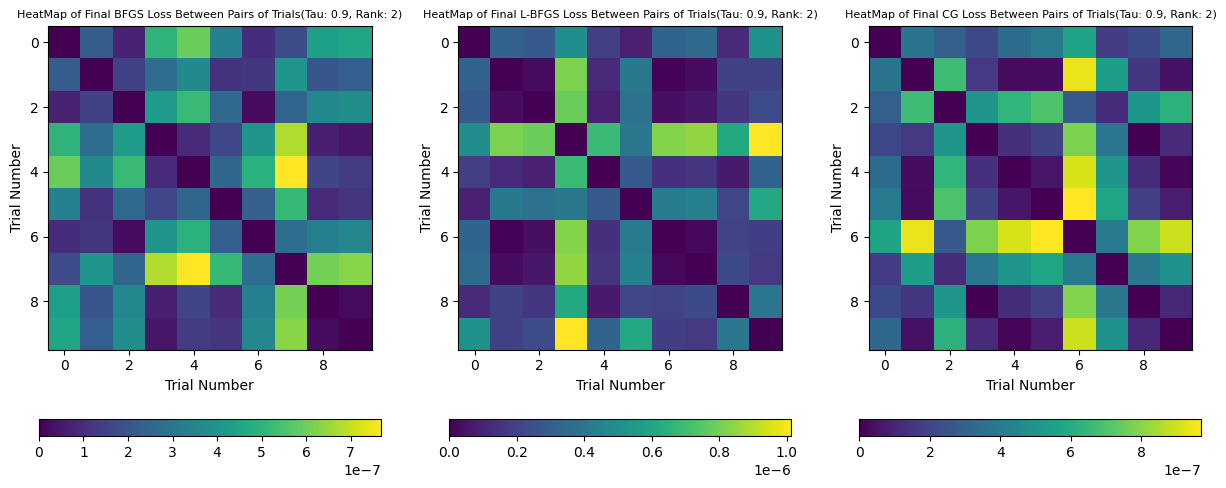

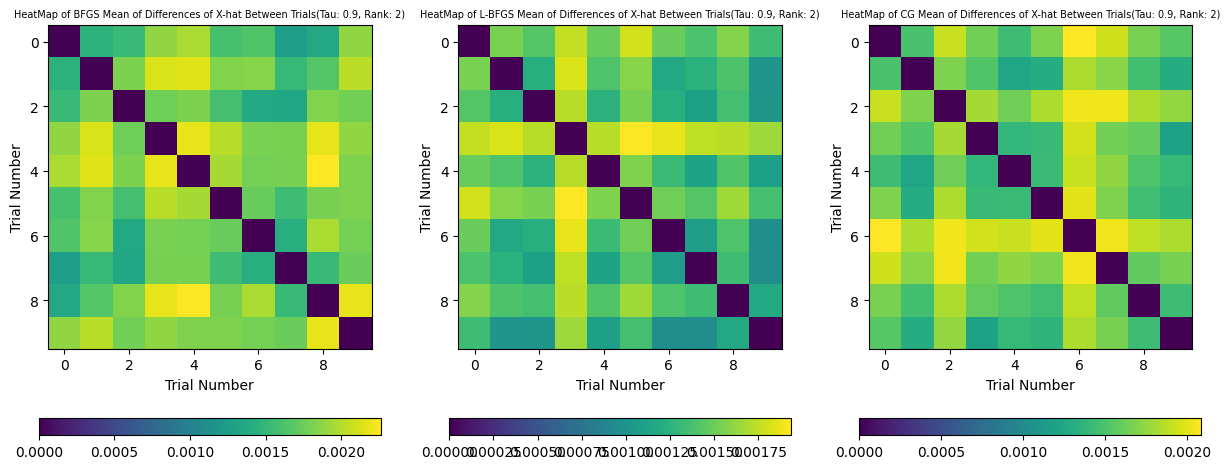

In [ ]:
# 6 Setup HeatMap
Plot_HeatMap(all_bfgs_final_loss_6, all_lbfgs_final_loss_6, all_cg_final_loss_6, all_bfgs_predict_array_6, all_lbfgs_predict_array_6, all_cg_predict_array_6, tau_6, rank_6)

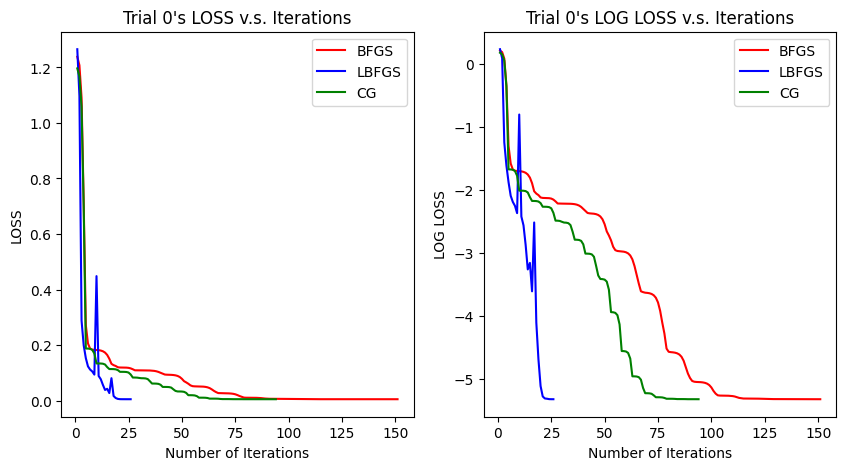

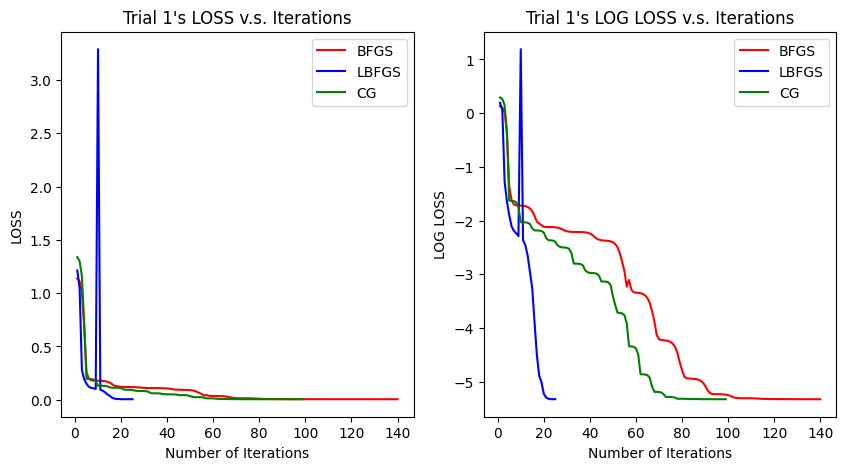

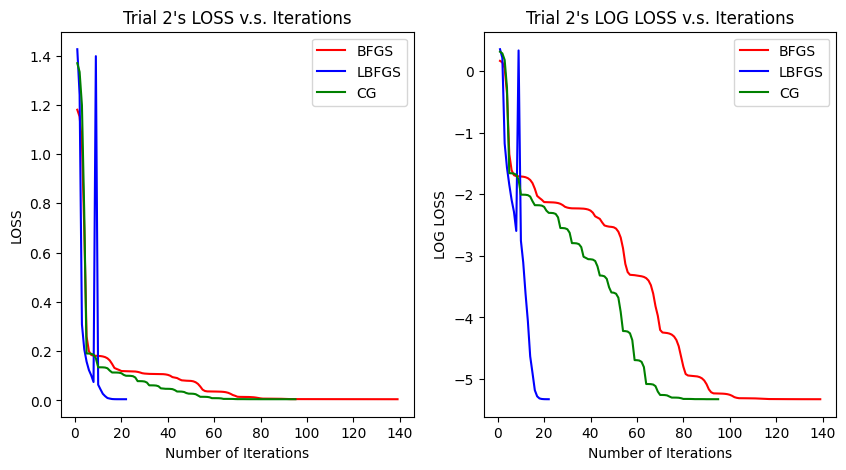

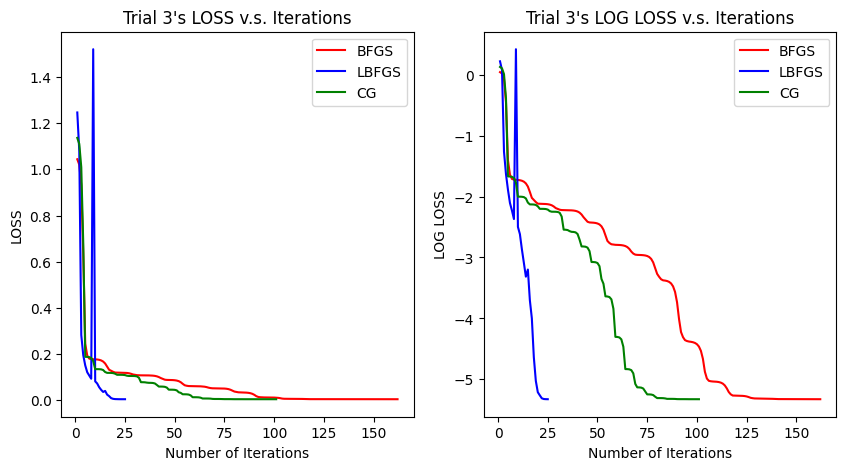

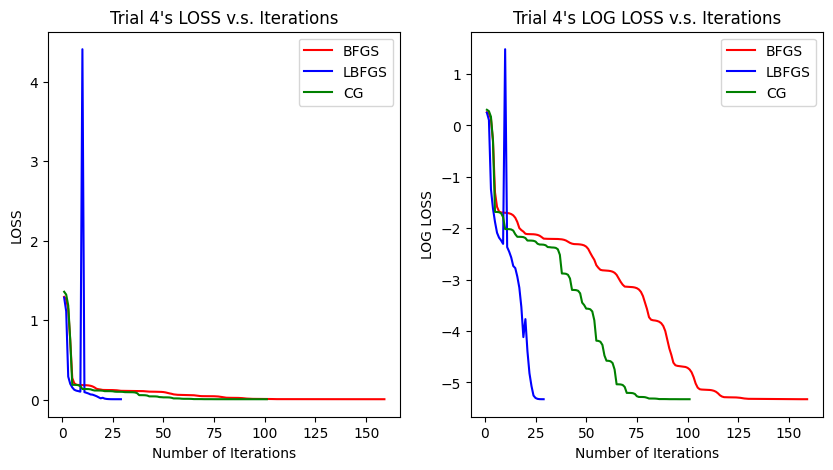

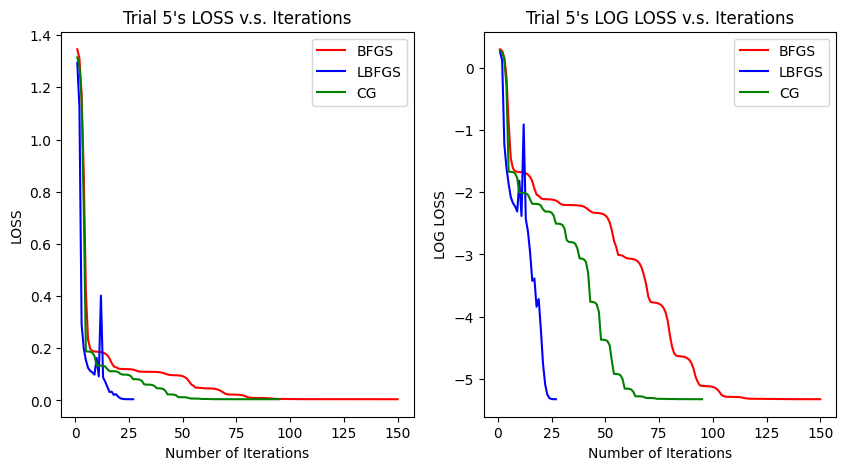

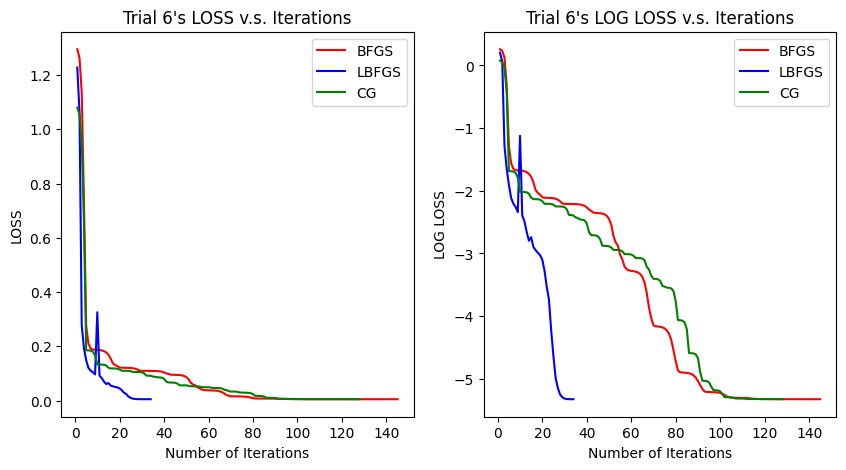

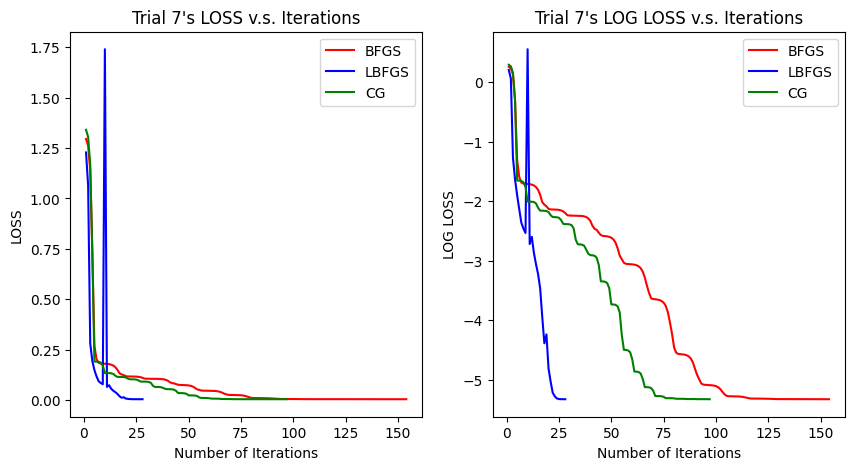

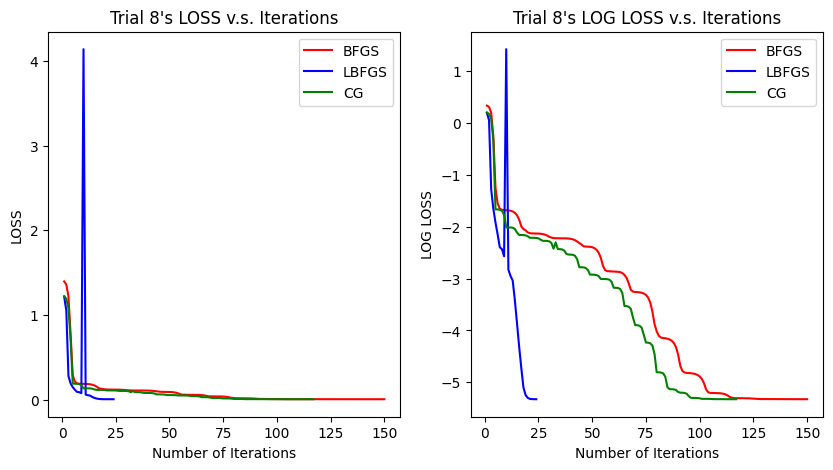

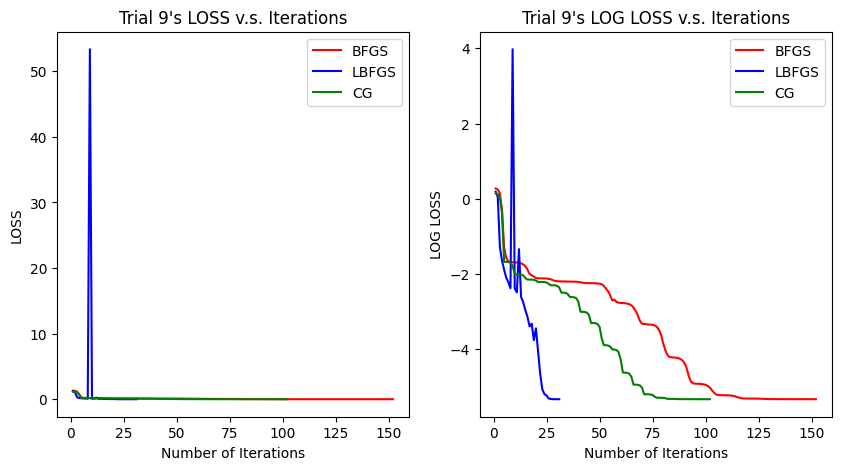

In [ ]:
# SETUP 6 Plot
for i in range(10):
  plotter(i, all_bfgs_loss_arrays_6[i], all_lbfgs_loss_arrays_6[i], all_cg_loss_arrays_6[i])

# Setup 7
Rank 3


In [ ]:
#-----------------
# Configuration 7:

# Matrix Size: 200 * 200
# True R SD: 1
# True C SD: 1
# True U/V Mean: 0
# True U/V STD: 1
# Sigma = 0.3
# Missing Proportion: 0.3
# Model Rank: 3
# Tau: 0.1
# Seed: 100
# R,C initialize with Row/Col mean
#-----------------
rank_7 = 3
tau_7 = 0.1
mu_7 = 0
sd_7 = 1
all_bfgs_loss_arrays_7, all_lbfgs_loss_arrays_7, all_cg_loss_arrays_7, all_bfgs_final_loss_7, all_lbfgs_final_loss_7, all_cg_final_loss_7, all_bfgs_predict_array_7, all_lbfgs_predict_array_7, all_cg_predict_array_7 = run_algorithm_ten_trials_sep_init(X_normalized_sq, rank_7, tau_7, row_mean_sq, col_mean_sq, mu_7, sd_7)

BFGS Final Loss: 0.004858422148922554
SETUP 0 BFGS Takes about:  122.94664001464844  (s)
SETUP 0 BFGS Iterations:  200
------------------------------------
L-BFGS-B Final Loss: 0.004802901459431796
SETUP 0 LBFGS Takes about:  0.11477088928222656  (s)
SETUP 0 LBFGS Iterations:  41
------------------------------------
CG Final Loss: 0.004848488444687919
Trial 0 CG Takes about:  0.2465658187866211  (s)
Trial 0 CG Iterations:  144

BFGS Final Loss: 0.004852552425622938
SETUP 1 BFGS Takes about:  122.60723733901978  (s)
SETUP 1 BFGS Iterations:  198
------------------------------------
L-BFGS-B Final Loss: 0.004885244698110088
SETUP 1 LBFGS Takes about:  0.13167333602905273  (s)
SETUP 1 LBFGS Iterations:  27
------------------------------------
CG Final Loss: 0.0048610202491955095
Trial 1 CG Takes about:  0.2857022285461426  (s)
Trial 1 CG Iterations:  119

BFGS Final Loss: 0.004850968478554637
SETUP 2 BFGS Takes about:  135.7373616695404  (s)
SETUP 2 BFGS Iterations:  221
-----------------

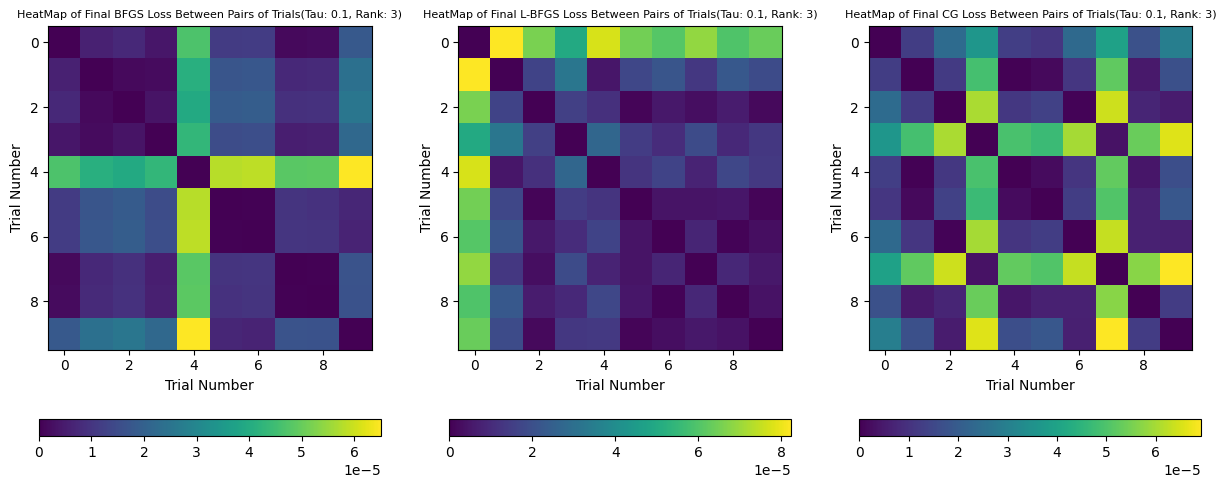

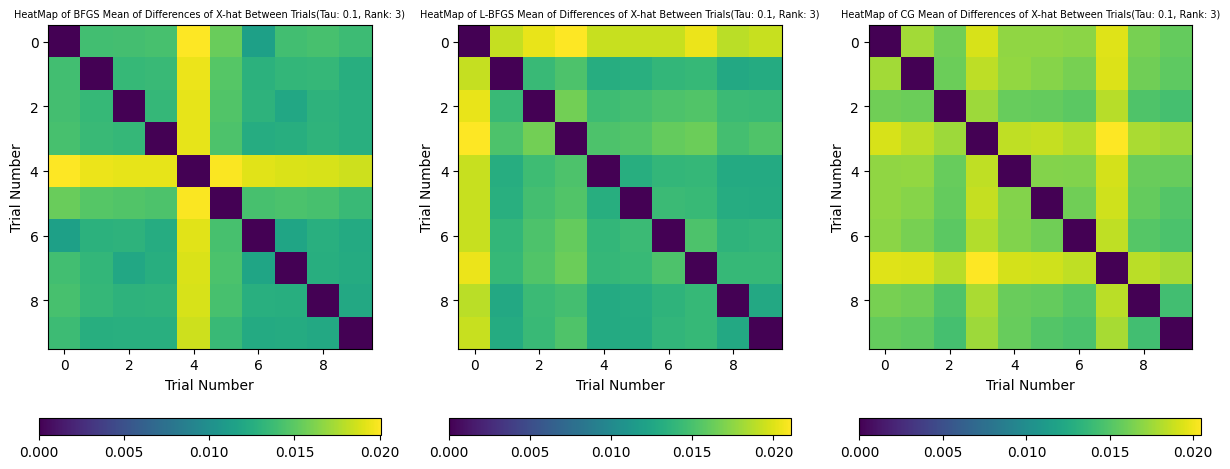

In [ ]:
# 7 Setup HeatMap
Plot_HeatMap(all_bfgs_final_loss_7, all_lbfgs_final_loss_7, all_cg_final_loss_7, all_bfgs_predict_array_7, all_lbfgs_predict_array_7, all_cg_predict_array_7, tau_7, rank_7)

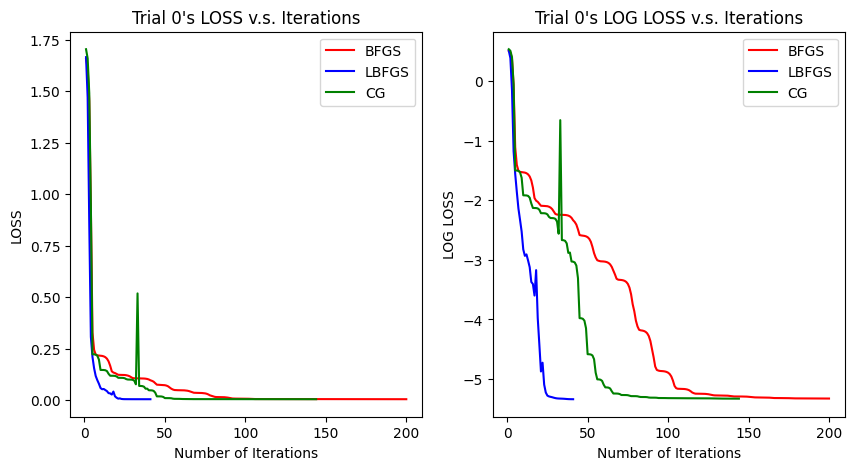

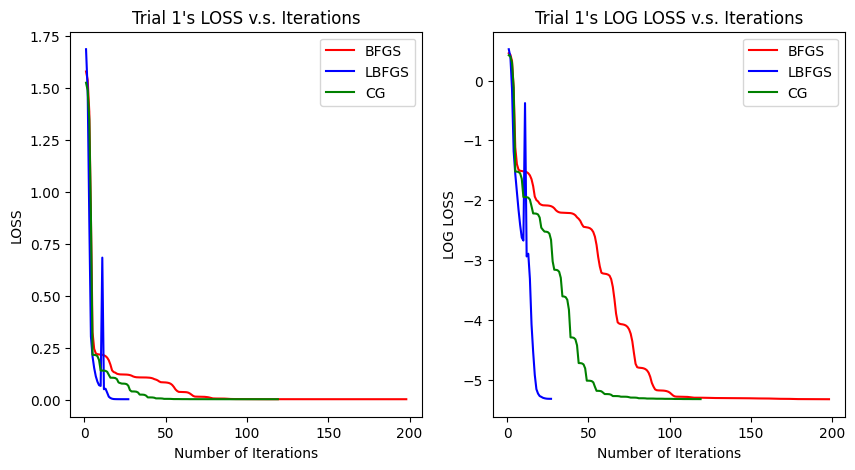

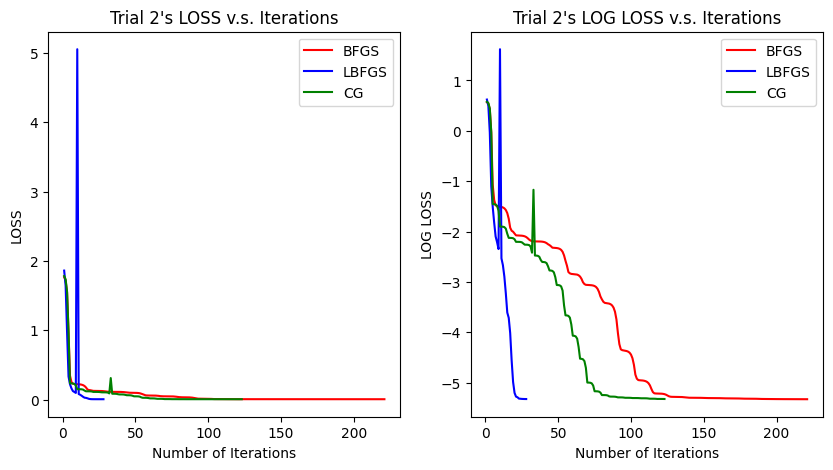

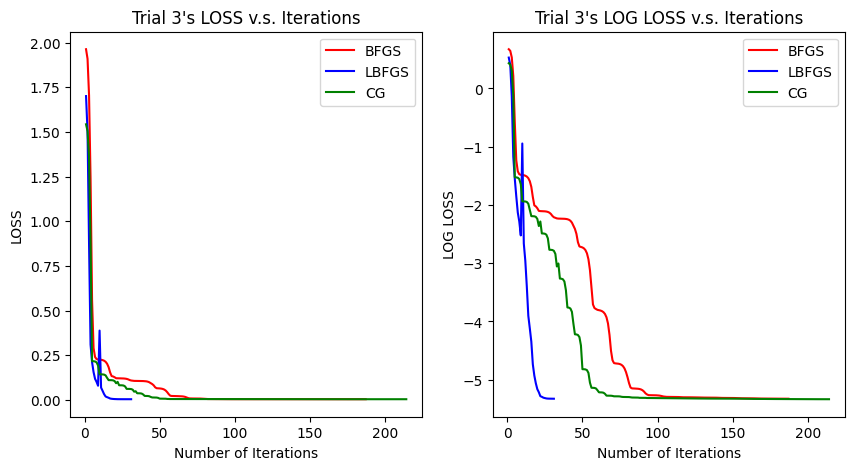

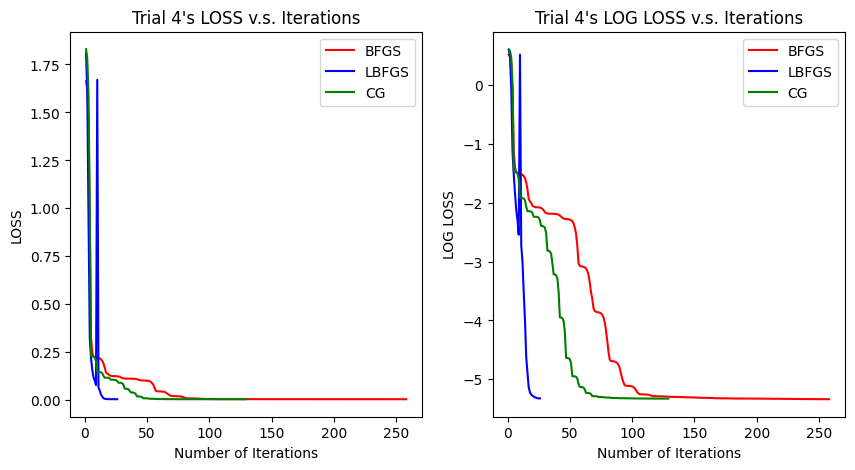

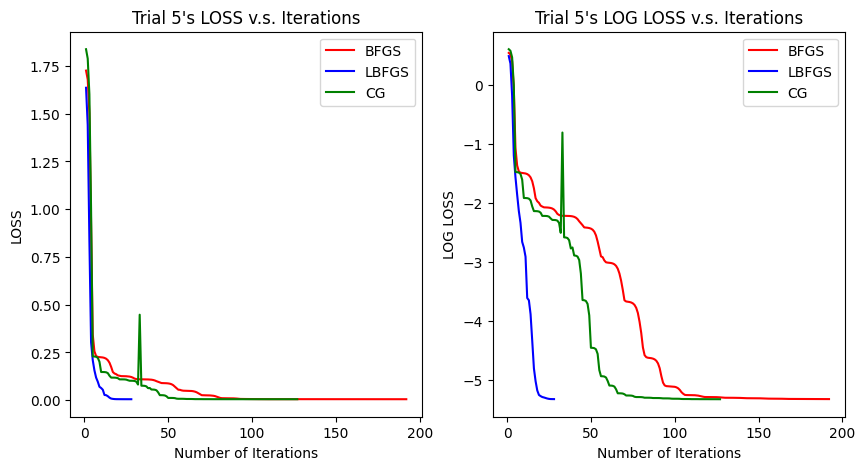

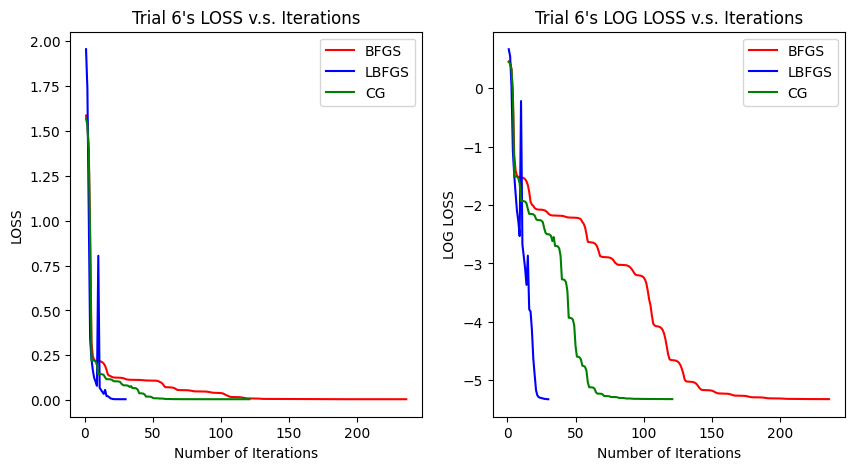

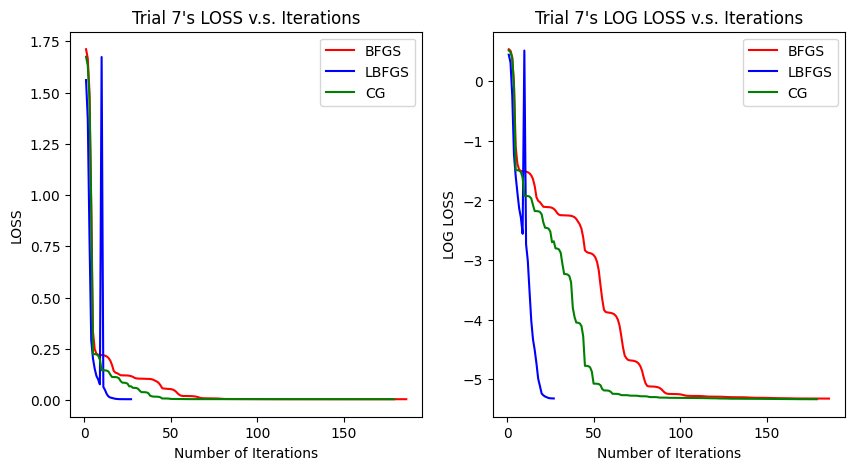

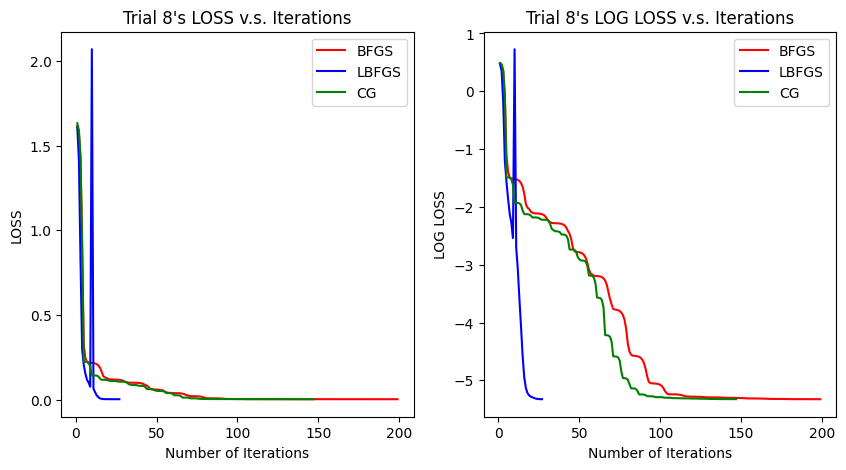

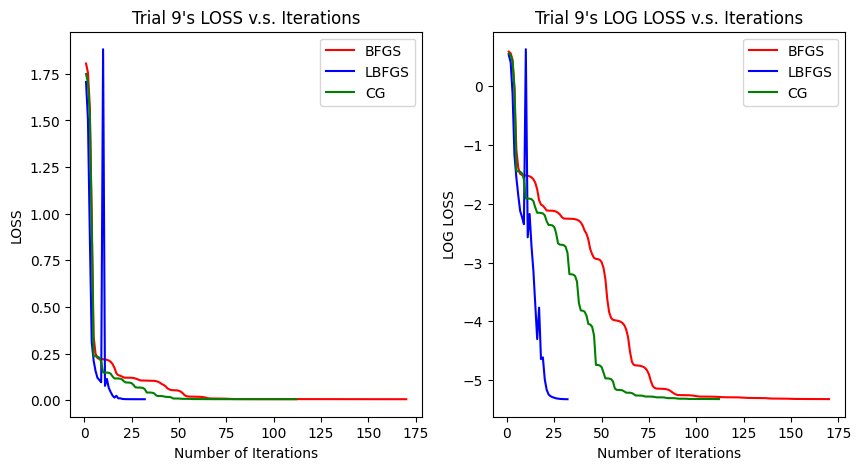

In [ ]:
# SETUP 7 Plot
for i in range(10):
  plotter(i, all_bfgs_loss_arrays_7[i], all_lbfgs_loss_arrays_7[i], all_cg_loss_arrays_7[i])

# Setup 8
Rank 4


In [ ]:
#-----------------
# Configuration 8:

# Matrix Size: 200 * 200
# True R SD: 1
# True C SD: 1
# True U/V Mean: 0
# True U/V STD: 1
# Sigma = 0.3
# Missing Proportion: 0.3
# Model Rank: 4
# Tau: 0.9
# Seed: 100
# R,C initialize with Row/Col mean
#-----------------
rank_8 = 4
tau_8 = 0.1
mu_8 = 0
sd_8 = 1
all_bfgs_loss_arrays_8, all_lbfgs_loss_arrays_8, all_cg_loss_arrays_8, all_bfgs_final_loss_8, all_lbfgs_final_loss_8, all_cg_final_loss_8, all_bfgs_predict_array_8, all_lbfgs_predict_array_8, all_cg_predict_array_8 = run_algorithm_ten_trials_sep_init(X_normalized_sq, rank_8, tau_8, row_mean_sq, col_mean_sq, mu_8, sd_8)

BFGS Final Loss: 0.004812386052749522
SETUP 0 BFGS Takes about:  230.52892637252808  (s)
SETUP 0 BFGS Iterations:  198
------------------------------------
L-BFGS-B Final Loss: 0.004655765963884015
SETUP 0 LBFGS Takes about:  0.10011744499206543  (s)
SETUP 0 LBFGS Iterations:  38
------------------------------------
CG Final Loss: 0.0046818771267183555
Trial 0 CG Takes about:  0.3551764488220215  (s)
Trial 0 CG Iterations:  208

BFGS Final Loss: 0.004624010887927791
SETUP 1 BFGS Takes about:  442.66023778915405  (s)
SETUP 1 BFGS Iterations:  378
------------------------------------
L-BFGS-B Final Loss: 0.004643309045908234
SETUP 1 LBFGS Takes about:  0.09778118133544922  (s)
SETUP 1 LBFGS Iterations:  40
------------------------------------
CG Final Loss: 0.004719966850962327
Trial 1 CG Takes about:  0.3969841003417969  (s)
Trial 1 CG Iterations:  236

BFGS Final Loss: 0.004801818788689865
SETUP 2 BFGS Takes about:  250.92008900642395  (s)
SETUP 2 BFGS Iterations:  215
----------------

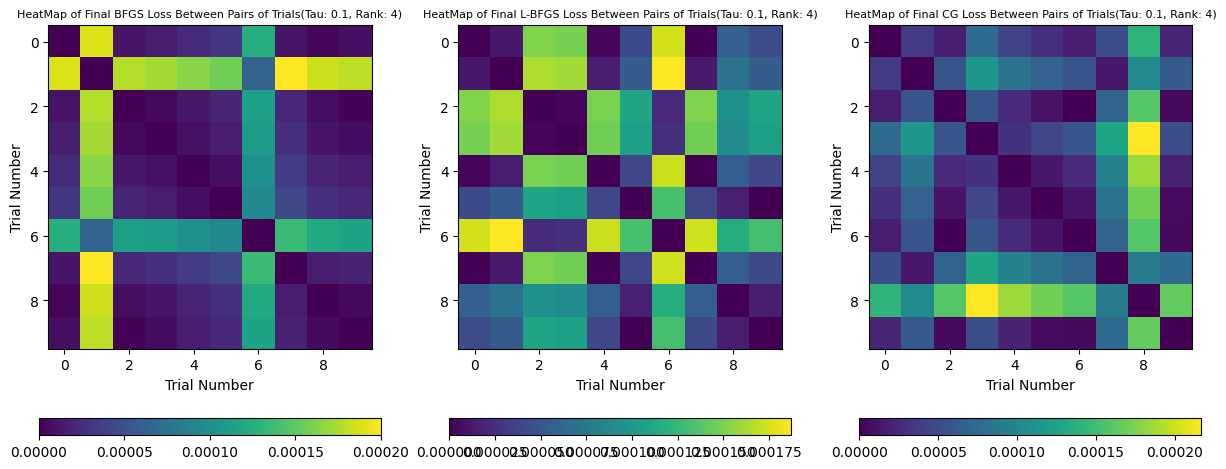

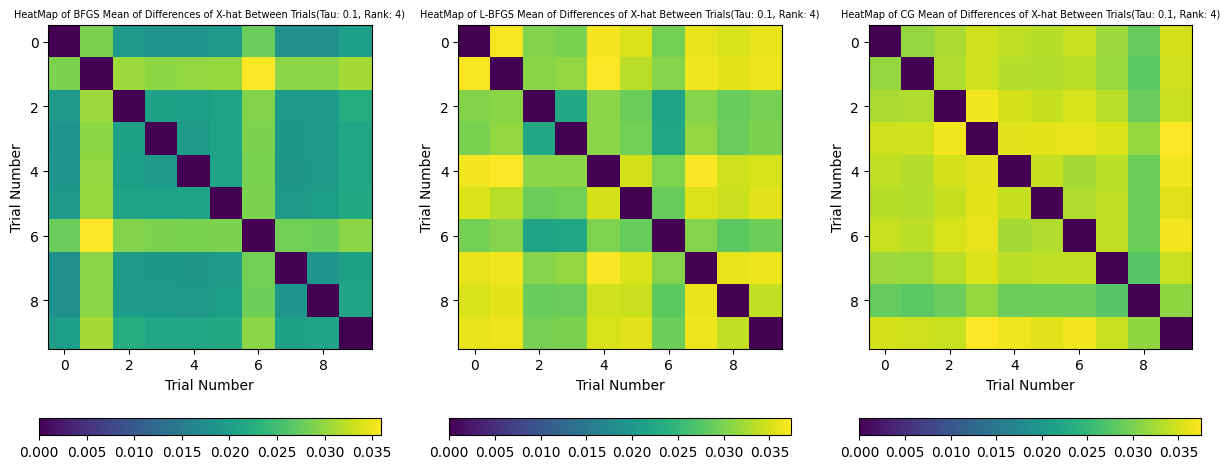

In [ ]:
# 8 Setup HeatMap
Plot_HeatMap(all_bfgs_final_loss_8, all_lbfgs_final_loss_8, all_cg_final_loss_8, all_bfgs_predict_array_8, all_lbfgs_predict_array_8, all_cg_predict_array_8, tau_8, rank_8)

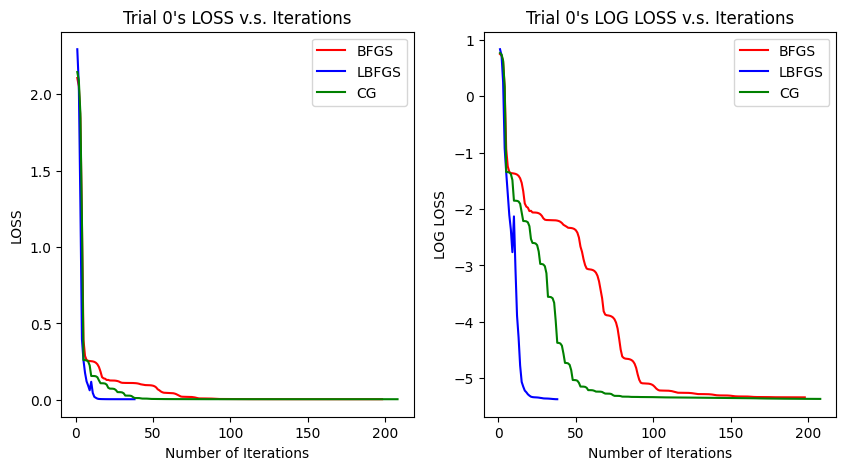

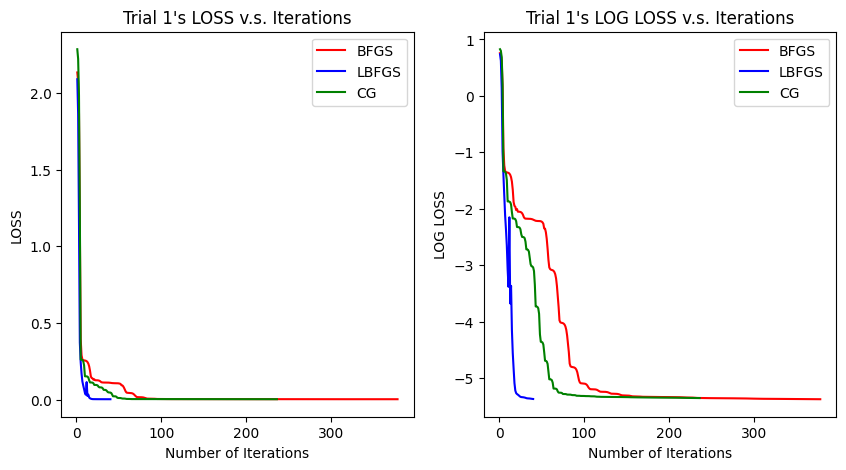

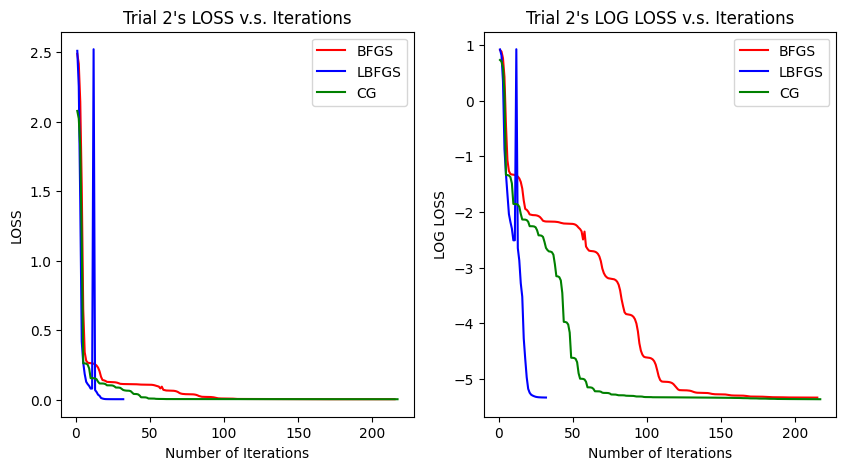

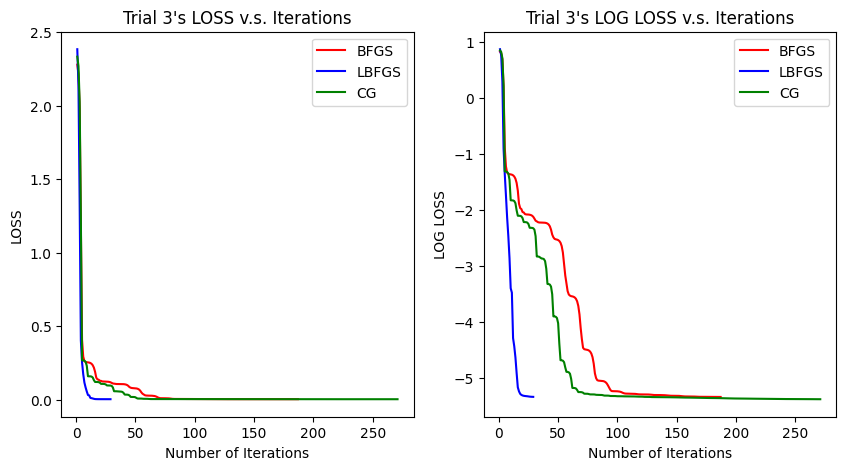

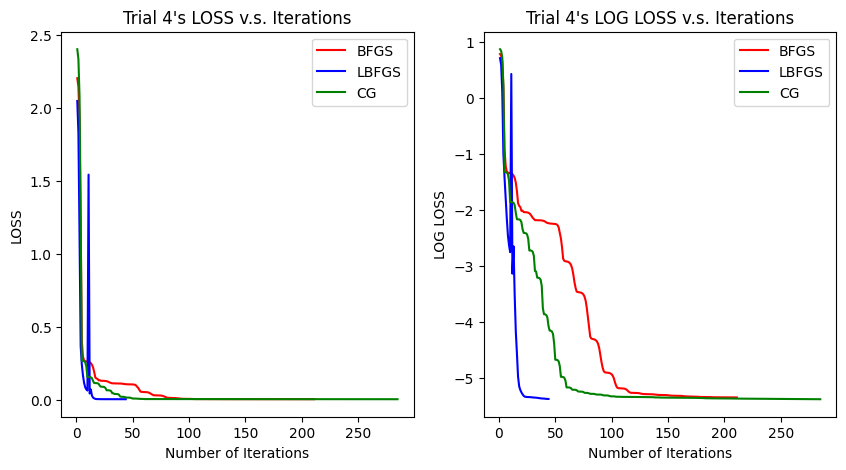

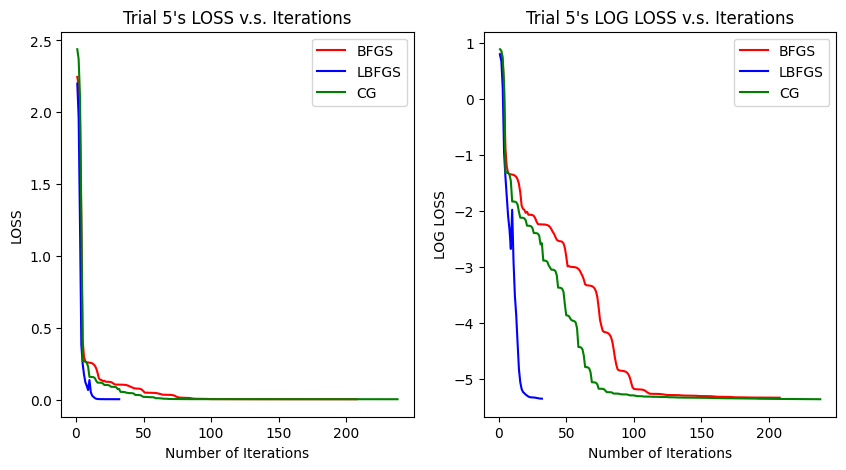

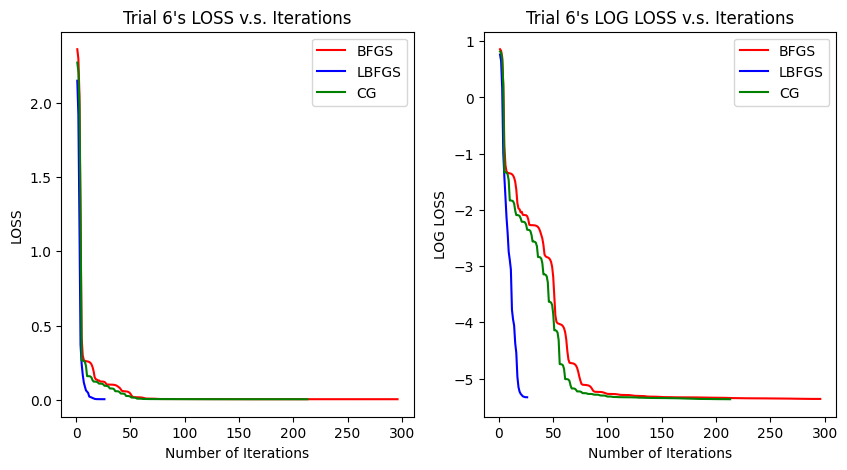

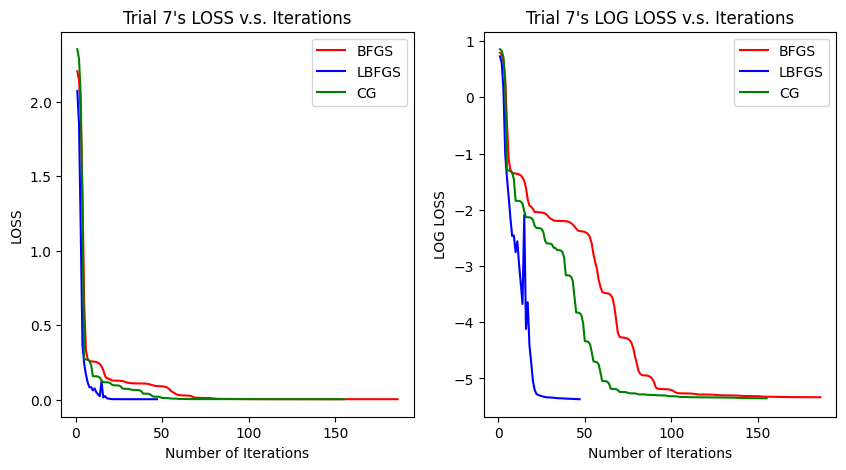

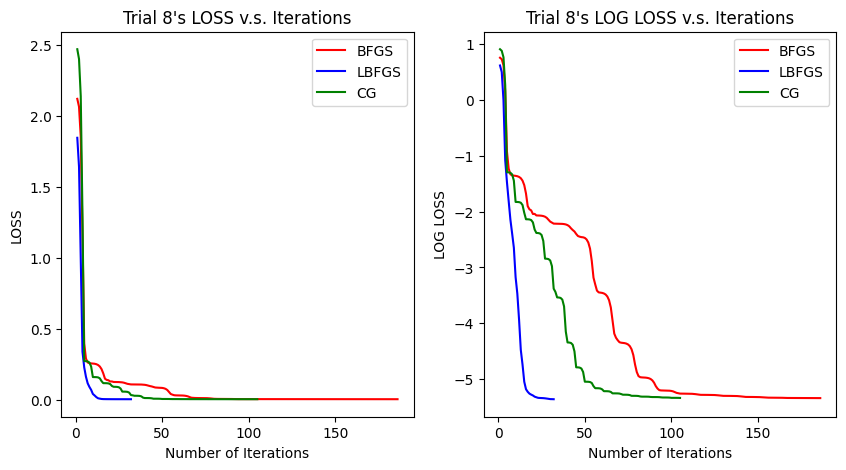

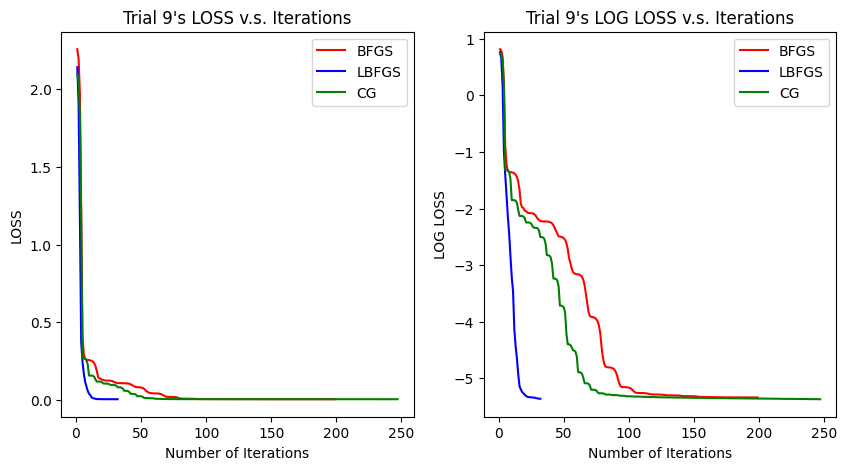

In [ ]:
# SETUP 8 Plot
for i in range(10):
  plotter(i, all_bfgs_loss_arrays_8[i], all_lbfgs_loss_arrays_8[i], all_cg_loss_arrays_8[i])

# Setup 9
Size of Actual Data


In [ ]:
#-----------------
# Configuration 9:

# Matrix Size: 288 * 334
# True R SD: 1
# True C SD: 1
# True U/V Mean: 0
# True U/V STD: 1
# Sigma = 0.3
# Missing Proportion: 0.3
# True UV Rank: 2
# Model Rank: 3
# Tau: 0.9
# Seed: 100
# R,C initialize with Row/Col mean
#-----------------
rank_9 = 3
tau_9 = 0.9
mu_9 = 0
sd_9 = 1
X_config_9, X_normalized_9, X_new_9, true_r_config_9, true_c_config_9, true_u_congfig_9, true_v_config_9, row_mean_9, col_mean_9 = get_normalized_X(m=288, n=334, r_sd=1, c_sd=1, u_sd=1,v_sd=1,sigma=0.3,na_portion=0.3, rank=2)
all_bfgs_loss_arrays_9, all_lbfgs_loss_arrays_9, all_cg_loss_arrays_9, all_bfgs_final_loss_9, all_lbfgs_final_loss_9, all_cg_final_loss_9, all_bfgs_predict_array_9, all_lbfgs_predict_array_9, all_cg_predict_array_9 = run_algorithm_ten_trials_sep_init(X_normalized_9, rank_9, tau_9, row_mean_9, col_mean_9, mu_9, sd_9)

MEAN -0.008341727605533152
STD:  2.106536332791277
NEW ERROR_SD:  0.14241387405954847
[[-0.20464149 -1.09206572  0.49934891 ...         nan         nan
          nan]
 [-0.79303429 -0.07798051  0.16921388 ... -0.3196703  -2.52877654
          nan]
 [ 0.8639689  -0.06077027         nan ... -0.19129679 -0.13613881
   1.19179489]
 ...
 [-0.21539359 -0.81455629         nan ...         nan -1.53212263
  -0.0782048 ]
 [-0.67264093 -0.49772609  0.0027275  ... -1.32182924         nan
          nan]
 [ 1.33450436         nan         nan ... -0.82676949         nan
          nan]]
NEW MEAN:  1.6849733622091866e-18
NEW STD:  0.9999999999999999
BFGS Final Loss: 0.0049263946684431755
SETUP 0 BFGS Takes about:  335.40180110931396  (s)
SETUP 0 BFGS Iterations:  157
------------------------------------
L-BFGS-B Final Loss: 0.004873834486605796
SETUP 0 LBFGS Takes about:  0.1617748737335205  (s)
SETUP 0 LBFGS Iterations:  28
------------------------------------
CG Final Loss: 0.004869534665993365
Trial

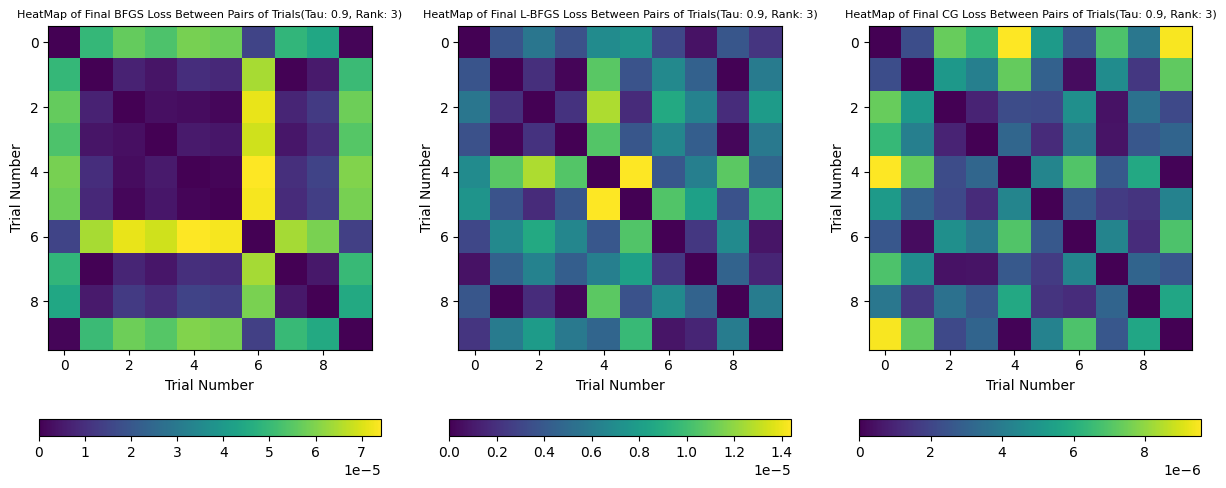

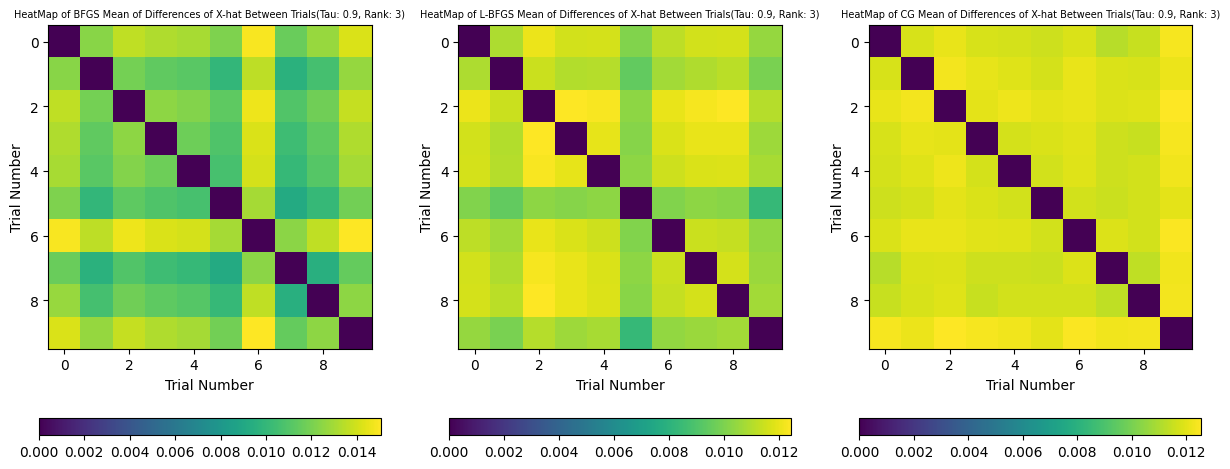

In [ ]:
# 9 Setup HeatMap
Plot_HeatMap(all_bfgs_final_loss_9, all_lbfgs_final_loss_9, all_cg_final_loss_9, all_bfgs_predict_array_9, all_lbfgs_predict_array_9, all_cg_predict_array_9, tau_9, rank_9, 288, 334)

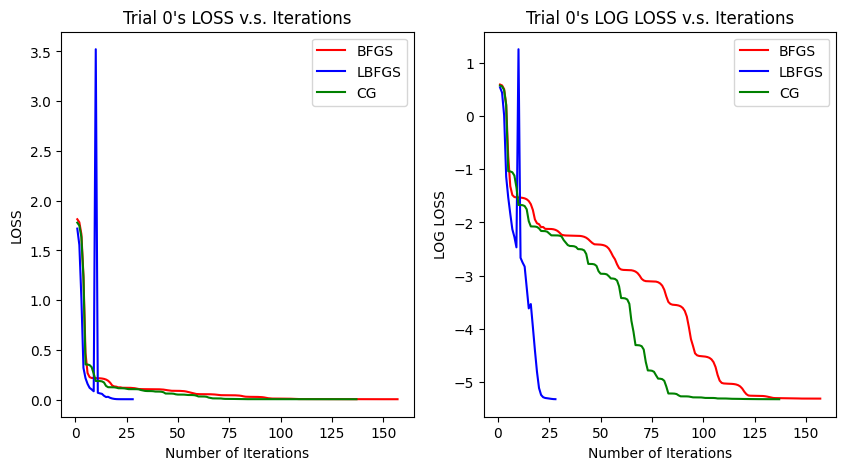

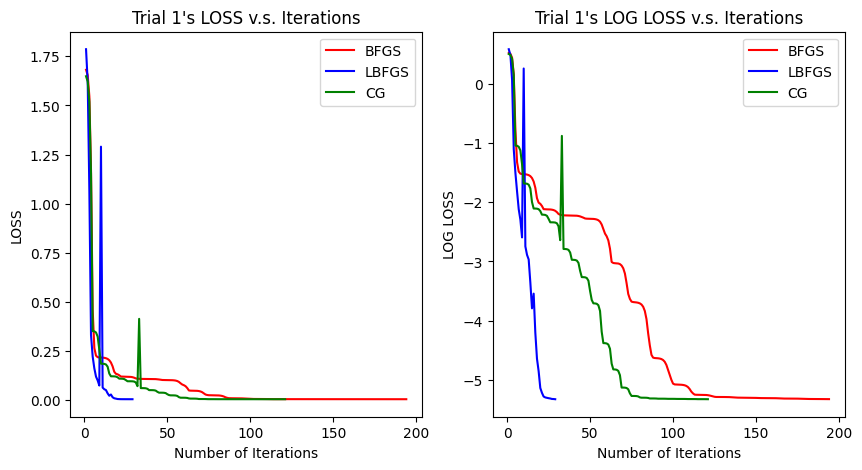

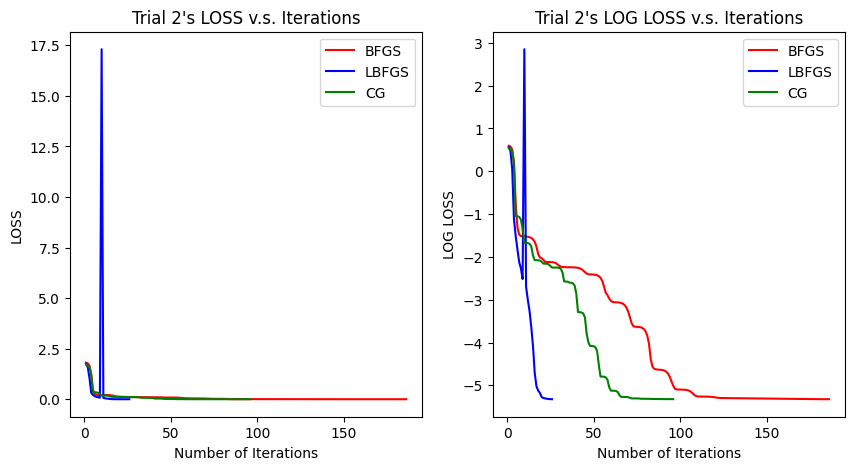

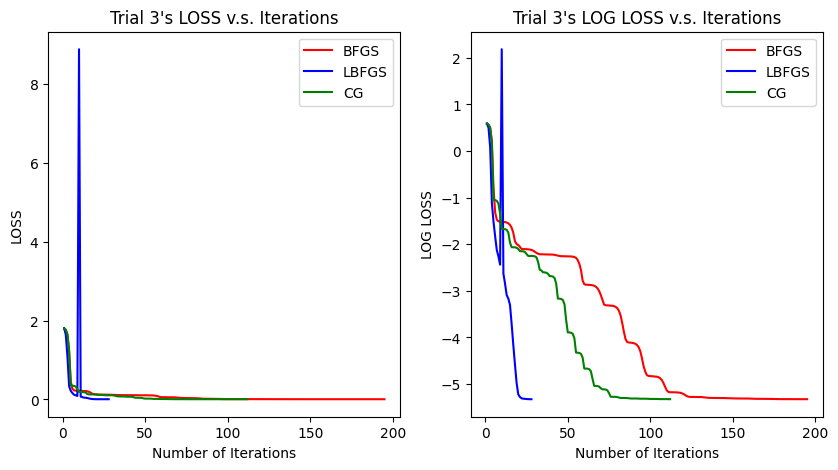

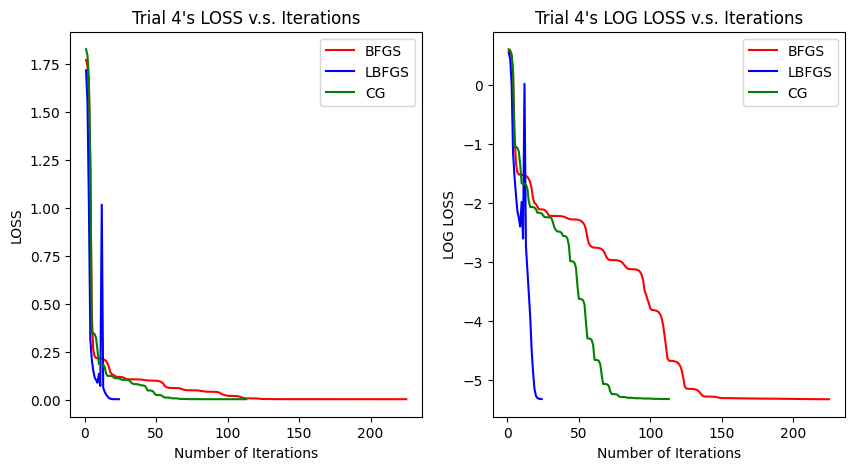

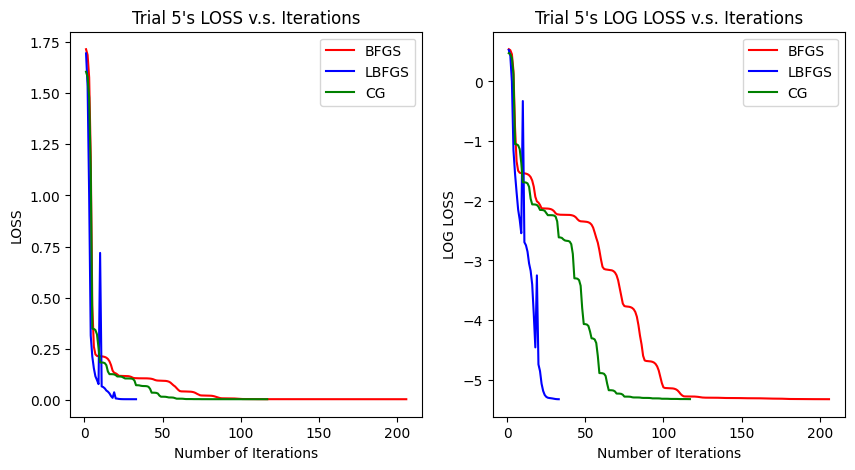

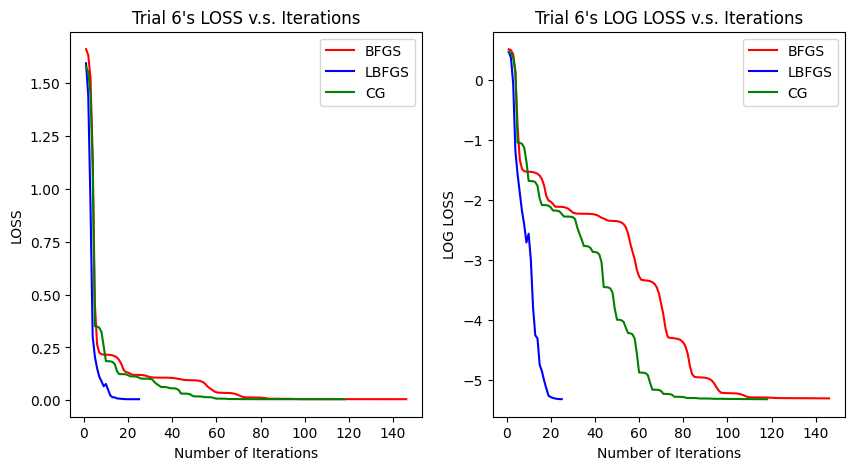

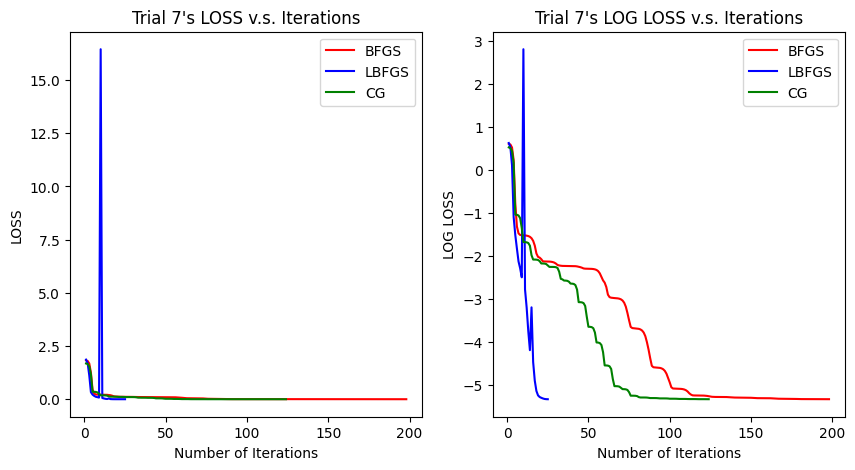

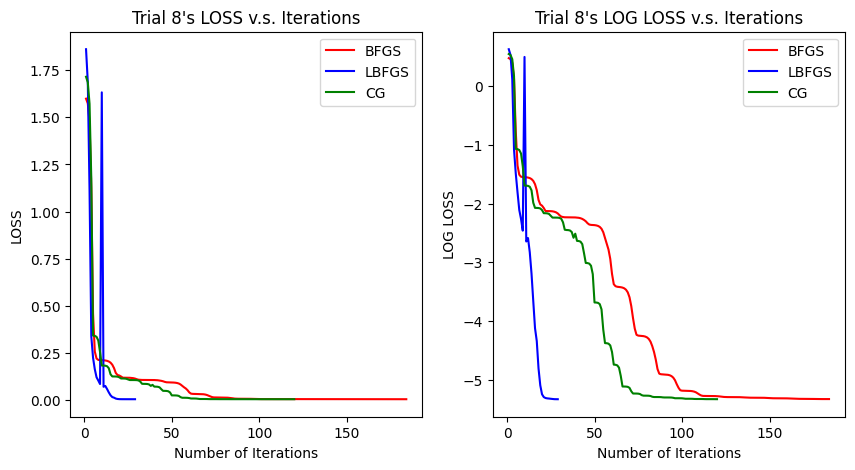

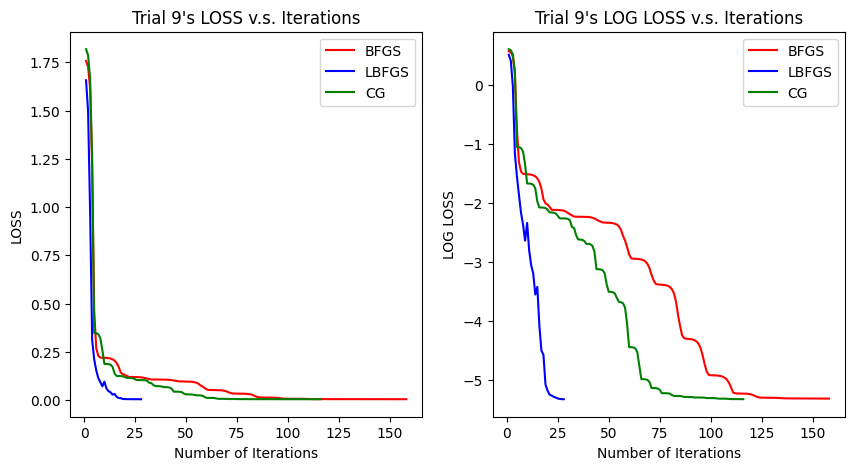

In [ ]:
# SETUP 9 Plot
for i in range(10):
  plotter(i, all_bfgs_loss_arrays_9[i], all_lbfgs_loss_arrays_9[i], all_cg_loss_arrays_9[i])

In [ ]:
# X_hat = R[:, np.newaxis] + C + U @ V.T
# X_hat

# X_hat_l = R_l[:, np.newaxis] + C_l, + U_l @ V_l.T
# X_hat_l

In [ ]:
# print("BFGS Feature Difference: ", X_hat - mu_X)
# #type(X_hat)
# #X_hat.shape
# residual = (X_hat - mu_X).ravel().std()
# print("BFGS Residual: ", residual)
# #type(residual)
# # plt.hist(residual)
# print("LBFGS Featrue Difference: ", X_hat_l - mu_X)
# residual_l = (X_hat_l - mu_X).ravel().std()
# print("LBFGS Residual: ", residual_l)

In [ ]:
# print("BFGS R's diff: ",true_r - R)
# print("LBFGS R's diff: ", true_r - R_l)

In [ ]:
# print("BFGS C's difference: ", true_c - C)
# print("LBFGS C's difference: ", true_c - C_l)

In [ ]:
# print("BFGS difference in outer: ", np.outer(U, V) - np.outer(true_u, true_v))
# print("LBFGS difference in outer: ", np.outer(U_l, V_l) - np.outer(true_u, true_v))